<br>
<a href="https://www.nvidia.com/en-us/training/">
    <div style="width: 55%; background-color: white; margin-top: 50px;">
    <img src="https://dli-lms.s3.amazonaws.com/assets/general/nvidia-logo.png"
         width="400"
         height="186"
         style="margin: 0px -25px -5px; width: 300px"/>
</a>
<h1 style="line-height: 1.4;"><font color="#76b900"><b>Physics NeMo External Aerodynamics</h1>
<h2><b>Notebook 1:</b> Preprocessing the Ahmed Body Surface Dataset</h2>
<br>

## Introduction

For educational purposes, it's important to use lightweight datasets that are easy to store and manage, especially for users who may not have access to high-performance computing resources. One such dataset is the **Ahmed body surface data**, which includes 3D surface geometry, pressure and wall shear stress data for variations in the Ahmed body geometry and inlet Reynolds number. This dataset is a great choice because it is relatively small in size, yet provides valuable information about aerodynamic simulations. It’s ideal for teaching and experimentation, as it won’t demand excessive storage or computational power. *Note that this dataset was created by the NVIDIA PhysicsNeMo development team and differs from other similar datasets hosted on cloud platforms like AWS.* As mentioned already the complete Ahmed body surface dataset is hosted on NGC and accessible from the following link:
https://catalog.ngc.nvidia.com/orgs/nvidia/teams/physicsnemo/resources/physicsnemo_ahmed_body_dataset

**Before proceeding, navigate to the data directory and make sure that the Ahmed body dataset is downloaded properly. The folder structure should be:**
```bash
physicsnemo_ahmed_body_dataset_vv1/dataset
├── train/
├── train_info/
├── train_stl_files/
├── validation/
├── validation_info/
├── validation_stl_files/
├── test/
├── test_info/
├── test_stl_files/
```


In this notebook, we will walk through the preprocessing steps required to prepare the **Ahmed body surface dataset** for training with the **DoMINO model**, which predicts surface quantities such as pressure and wall shear stress.  

For **surface traning** the DoMINO model requires **3D surface geometry** in both **STL** and **VTP (VTK PolyData)** formats:  

- **STL (Stereolithography)**  
  - A widely used file format for representing 3D surface geometry in computer-aided design (CAD) applications.  
  - Describes the surface as a collection of triangular facets, suitable for computational geometry, 3D printing, and mesh-based simulations.  

- **VTP (VTK PolyData)**  
  - A format from the **VTK (Visualization Toolkit)** that stores surface data as **PolyData**, representing points, lines, and polygons on the surface.  
  - Commonly used in CFD and physics-informed simulations.  

Both data formats are required for DoMINO surface training:  

- **STL files** provide the 3D geometry informattion.  
- **VTP files** store additional surface quantities such as pressure and wall shear stress.  

To make the dataset easier to use in machine learning workflows and feeding into the GPU, the **data is converted into NumPy arrays (NPY format)**:  

- Allows efficient numerical operations and faster computations.  
- Facilitates convenient storage on disk, making the data readily accessible for training and further analysis.

## Table of Contents
- [Step 1: Define Experiment Parameters and Dependencies](#step-1-define-experiment-parameters-and-dependencies)
- [Step 2: Investigating the Ahmed Body Dataset](#Step-2-investigating-the-ahmed-body-dataset)
- [Step 3: Exporting a NumPy Representations VTP + STL + Global Parameters → NumPy](#Step-3-exporting-a-numpy-representations-vtp-+stl-+global-parameters-→-numpy)
- [Step 4: Data Aggregation and Statistical Analysis Overview from .npy Files](#Step-4-data-aggregation-and-statistical-analysis-overview-from-.npy-files)


### **Step 1: Define Experiment Parameters and Dependencies**

The first step in training the DoMINO model on the Ahmed body surface dataset is to set up our experiment environment and define the necessary parameters. This includes specifying paths to our data, configuring training settings, and ensuring all required libraries are available.

Key components we need to set up:
- Data paths for training and validation sets
- Model hyperparameters and training configurations
- Visualization settings for results
- Required Python libraries for mesh processing and deep learning

### Loading Required Libraries

Before we proceed with the experiment setup, let's first import all the necessary libraries. These libraries will be used for:
- Mesh processing and visualization (`vtk`, `pyvista`)
- Data handling and file operations (`pathlib`, `concurrent.futures`)
- Progress tracking and visualization (`tqdm`, `matplotlib`)
- PyTorch provides data primitives: `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as your own data. `Dataset` stores the samples and their corresponding labels.
- Important utilities for data processing and training, testing DoMINO (`modulus.utils.domino.utils`)

### Dependencies
Ensure that the required Python libraries are installed:

In [1]:
## Not needed in course environment. Needed elsewhere
# !pip install numpy pyvista vtk matplotlib tqdm numpy-stl
# !apt update && apt install -y xvfb

!pip list | grep -E 'numpy|pyvista|vtk|matplotlib|tqdm|numpy-stl|nvidia-physicsnemo'
!apt list | grep -E 'xvfb'

matplotlib                 3.10.3
matplotlib-inline          0.1.7
numpy                      1.26.4
numpy-stl                  3.2.0
nvidia-physicsnemo         1.2.0
nvidia-physicsnemo.sym     2.2.0
pyvista                    0.46.2
tqdm                       4.67.1
vtk                        9.5.0


python3-pytest-xvfb/noble 3.0.0-2 all
python3-xvfbwrapper/noble 0.2.9-5 all
xvfb/noble-updates,noble-security,now 2:21.1.12-1ubuntu1.4 amd64 [installed]


Then, we can go ahead and import the necessary utilities:

In [2]:
import os
import time
import random
from concurrent.futures import ProcessPoolExecutor
from pathlib import Path
from typing import Union

import numpy as np
import pyvista as pv
import vtk
from stl import mesh
from tqdm import tqdm

from physicsnemo.utils.domino.utils import *
from torch.utils.data import Dataset

## Start the xvfb process for plotting in this environment
pv.start_xvfb()
os.environ["XDG_RUNTIME_DIR"] = "/tmp"

### Experiment Parameters and Variables

In this section, we set up all the essential parameters and variables required for the Ahmed body experiment. 


Once done, we'll set some variables for our data path and relevant physical properties which will be used across our simulations.

In [3]:
# Directory and Path Configuration
DATA_DIR = Path("/workspace/physicsnemo_ahmed_body_dataset_vv1/dataset")  # Root directory for dataset

# Physical Variables
VOLUME_VARS = ["p"]  # Volume variables to predict (pressure)
SURFACE_VARS = ["p", "wallShearStress"]  # Surface variables to predict
GLOBAL_PARAMS_TYPES = {"inlet_velocity": "vector", "air_density": "scalar"}
GLOBAL_PARAMS_REFERENCE = {"inlet_velocity": [50.0], "air_density": 1.226}

<hr><br>

### **Step 2: Investigating the Ahmed Body Dataset**

Before diving into data processing, let's understand what we're working with. The Ahmed body is a simplified vehicle geometry that has become the gold standard for validating automotive CFD simulations. Created by S.R. Ahmed in the 1980s, this geometry captures the essential aerodynamic features of road vehicles while remaining simple enough for systematic study.

### Why Ahmed Body?

The Ahmed body strikes a perfect balance for machine learning applications:
- **Simple enough** to generate large datasets quickly
- **Complex enough** to exhibit realistic aerodynamic phenomena like flow separation and wake formation
- **Well-studied** with extensive experimental validation data
- **Parameterizable** allowing systematic variations in geometry

For our training, this translates to a dataset where we can confidently validate our models against decades of research.

Let's go ahead and take a high-level look at the data:


In [4]:
# First, let's check that our data has finished downloading
import os
import time
from pathlib import Path

# Quick overview of our data structure
DATA_DIR = Path("/workspace/physicsnemo_ahmed_body_dataset_vv1/dataset")
print(f"\nDataset size: {sum(f.stat().st_size for f in DATA_DIR.rglob('*') if f.is_file()) / (1024**3):.2f} GB")

# Show the organization
for split in ["train", "validation", "test"]:
    split_dir = DATA_DIR / split
    if split_dir.exists():
        vtp_files = list(split_dir.glob("*.vtp"))
        print(f"{split.capitalize()}: {len(vtp_files)} VTP files")

# Show the organization
for split in ["train_stl_files", "validation_stl_files", "test_stl_files"]:
    split_dir = DATA_DIR / split
    if split_dir.exists():
        stl_files = list(split_dir.glob("*.stl"))
        print(f"{split.capitalize()}: {len(stl_files)} STL files")



Dataset size: 11.85 GB
Train: 408 VTP files
Validation: 50 VTP files
Test: 50 VTP files
Train_stl_files: 408 STL files
Validation_stl_files: 50 STL files
Test_stl_files: 50 STL files


The **VTP** (VTK PolyData) files store results from CFD simulations on various Ahmed body geometries under different flow conditions. Each file corresponds to a single simulation case, with variations in parameters such as inlet velocity, geometric modifications, and Reynolds number.

VTP files are XML-based and contain both geometry and physical field data on a surface mesh. When viewed in a text editor or processed by visualization tools (like ParaView), their structure includes:

- **Geometry:** 3D coordinates and surface mesh connectivity (points and polygons).

- **Physics:** Simulation results like surface pressure and wall shear stress, stored as scalar or vector fields attached to mesh points or cells.

- **Metadata:** Descriptive information such as data types, field names, number of points/elements, and possibly simulation-specific parameters (e.g., units, time step, or solver settings).

In contrast, the **STL** files only define the **3D geometry** of the Ahmed body. They describe the surface mesh using triangle facets but do not contain any physical data or metadata — making them suitable for shape definition but not simulation results.   


In [5]:
import vtk
import pyvista as pv
import numpy as np
from pathlib import Path

# Load and examine a sample VTP file
sample_vtp = "/workspace/data/train/case102.vtp"
mesh = pv.read(sample_vtp)

print("=== VTP File Analysis ===")
print(f"Number of points: {mesh.n_points:,}")
print(f"Number of cells: {mesh.n_cells:,}")
print(f"Surface area: {mesh.area:.3f} m²")

=== VTP File Analysis ===
Number of points: 76,975
Number of cells: 76,561
Surface area: 0.933 m²


If you investigate the `data` directory, you'll notice the `.vtk` files follow roughly this format:

```xml
<?xml version='1.0'?>
<!-- patch='ahmed_body' time='5000' index='5000' -->
<VTKFile type='PolyData' version='0.1' byte_order='LittleEndian' header_type='UInt64'>
  <PolyData>
    <FieldData>
      <DataArray type='Float32' Name='TimeValue' NumberOfTuples='1' format='binary'>
            BAAAAAAAAAAAQJxF  <!-- or some other small binary string -->
      </DataArray>
    </FieldData>
    <Piece NumberOfPoints='61887' NumberOfPolys='61538'>
      <Points>
        <DataArray type='Float32' Name='Points' NumberOfComponents='3' format='binary'>
            <!-- some big binary string -->
        </DataArray>
      </PointData>
    </Piece>
  </PolyData>
</VTKFile>
```

But on import you will also find other values, as discovered by pyvista on per-point binary decoding:

In [6]:
# Examine the data fields available
print(f"\nAvailable scalar fields:")
for name in mesh.array_names:
    data = mesh[name]
    print(f"  {name:18s} | shape={str(mesh[name].shape):12s} | range=[{np.min(data):11.4f}, {np.max(data):11.4f}]")


Available scalar fields:
  TimeValue          | shape=(1,)         | range=[  5000.0000,   5000.0000]
  k                  | shape=(76561,)     | range=[     0.0377,     33.1004]
  nut                | shape=(76561,)     | range=[     0.0000,      0.0003]
  omega              | shape=(76561,)     | range=[  1501.4154, 462836.9062]
  p                  | shape=(76561,)     | range=[ -3349.1636,   1012.6285]
  yPlus              | shape=(76561,)     | range=[     0.7372,    392.4779]
  U                  | shape=(76561, 3)   | range=[     0.0000,      0.0000]
  wallShearStress    | shape=(76561, 3)   | range=[   -17.2296,      5.2901]
  k                  | shape=(76561,)     | range=[     0.0377,     33.1004]
  nut                | shape=(76561,)     | range=[     0.0000,      0.0003]
  omega              | shape=(76561,)     | range=[  1501.4154, 462836.9062]
  p                  | shape=(76561,)     | range=[ -3349.1636,   1012.6285]
  yPlus              | shape=(76561,)     | range=

Let's visualize this data to understand what we're working with. 

**Per-element, we can figure out the body state with applied flow forces, as shown here:**

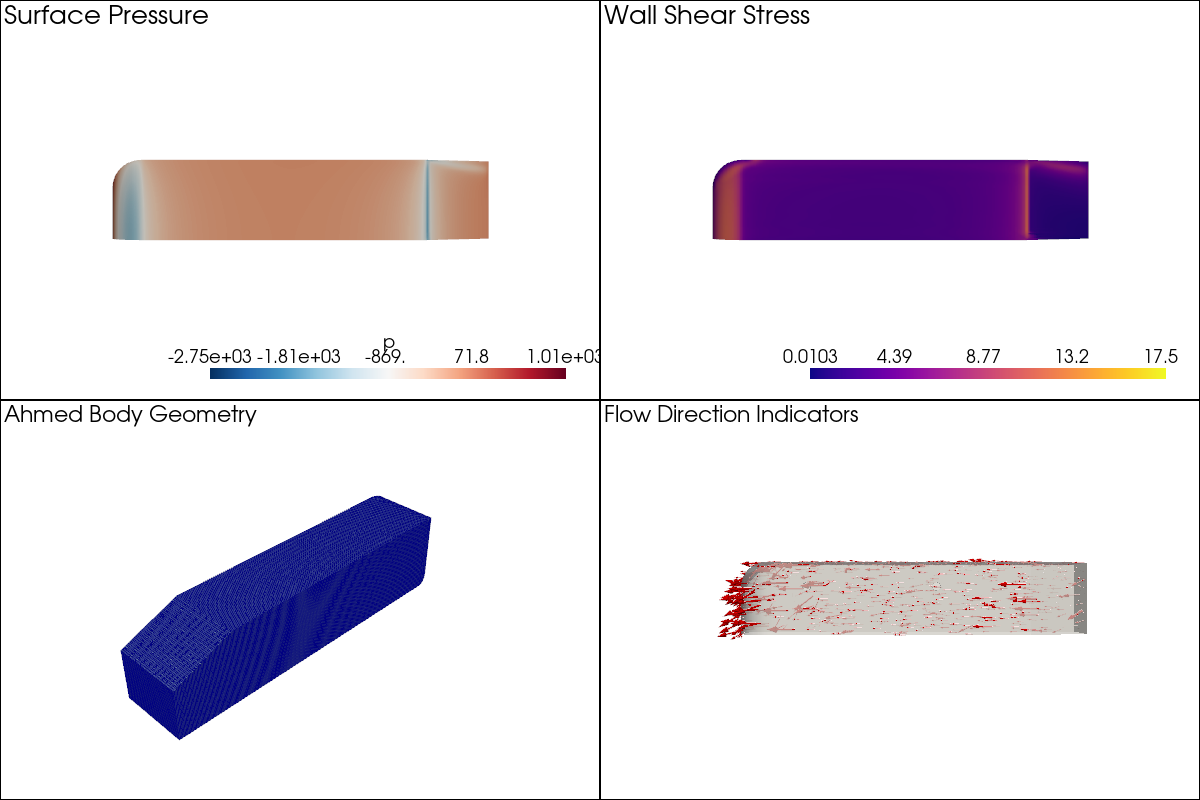

In [7]:
# Create a comprehensive visualization of our Ahmed body data
def plot_body_features(cfd_file, window_size=[1200, 800]):
    """
    Create a comprehensive visualization of our Ahmed body data which shows several key aspects:
    - Surface pressure, wall sheer stress, 3D geometry, and flow direction samples.
    - Visualization works for stl and vtp files, as both are supported with pv.Plotter.
    """
    plotter = pv.Plotter(shape=(2, 2), window_size=[1200, 800], off_screen=True)
    mesh = pv.read(cfd_file)
    
    # Surface pressure visualization
    plotter.subplot(0, 0)
    plotter.add_mesh(mesh, scalars='p', cmap='RdBu_r', show_edges=False)
    plotter.add_text("Surface Pressure", font_size=12)
    plotter.camera_position = 'xy'
    
    # Wall shear stress magnitude
    plotter.subplot(0, 1)
    shear_magnitude = np.linalg.norm(mesh['wallShearStress'], axis=1)
    plotter.add_mesh(mesh, scalars=shear_magnitude, cmap='plasma', show_edges=False)
    plotter.add_text("Wall Shear Stress", font_size=12)
    plotter.camera_position = 'xy'
    
    # Geometry overview
    plotter.subplot(1, 0)
    plotter.add_mesh(mesh, color='lightblue', show_edges=True, edge_color='navy', line_width=0.5)
    plotter.add_text("Ahmed Body Geometry", font_size=12)
    plotter.camera_position = 'iso'
    
    # Flow patterns (using shear stress vectors)
    plotter.subplot(1, 1)
    # Sample some points for vector visualization
    sample_indices = np.random.choice(mesh.n_cells, size=min(1000, mesh.n_points//10), replace=False)
    sample_points = mesh.points[sample_indices]
    sample_vectors = mesh['wallShearStress'][sample_indices]
    
    plotter.add_mesh(mesh, color='white', opacity=0.7)
    plotter.add_arrows(sample_points, sample_vectors, mag=0.01, color='red')
    plotter.add_text("Flow Direction Indicators", font_size=12)
    plotter.camera_position = 'xy'
    
    plotter.screenshot('ahmed_body_overview.png')
    plotter.show(jupyter_backend='static')

plot_body_features("/workspace/data/train/case102.vtp", window_size=[1200, 800])

Looking across testing examples, we can see some obvious variability in the models. As a convenience, the data is already augmented with geometric variations which should help us with training models and evaluating how well out model generalizes. 

case281 Statistics:
  Faces: 87,271
  Vertices: 87,716
  Surface Area: 1.060 m²
  Volume: 0.087 m³

case911 Statistics:
  Faces: 58,724
  Vertices: 59,109
  Surface Area: 0.716 m²
  Volume: 0.051 m³

case178 Statistics:
  Faces: 86,596
  Vertices: 87,027
  Surface Area: 1.036 m²
  Volume: 0.085 m³



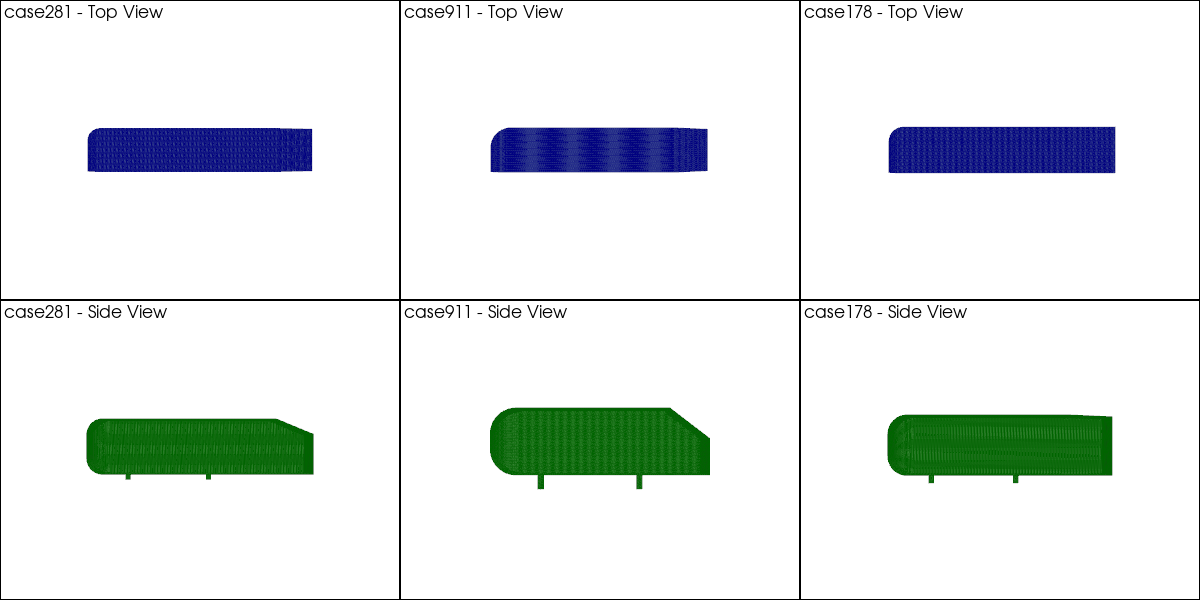

In [8]:
def plot_geometry_comparison(cfd_files, titles=None):
    """Create a side-by-side comparison of Ahmed body geometries. Specifically, top-view and side-view"""
    
    if titles is None:
        titles = [f"Case {i+1}" for i in range(len(cfd_files))]
    
    meshes = [pv.read(file) for file in cfd_files]
    meshes = [m for m in meshes if m is not None]  # Filter out failed loads
    
    # Create comparison visualization
    plotter = pv.Plotter(shape=(2, len(meshes)), window_size=[400*len(meshes), 600], off_screen=True)
    
    for i, (mesh, title) in enumerate(zip(meshes, titles)):
        # Top view
        plotter.subplot(0, i)
        plotter.add_mesh(mesh, color='lightblue', show_edges=True, edge_color='navy', line_width=0.3)
        plotter.add_text(f"{title} - Top View", font_size=10)
        plotter.camera_position = 'xy'
        plotter.camera.zoom(0.8)
        
        # Side view
        plotter.subplot(1, i)
        plotter.add_mesh(mesh, color='lightgreen', show_edges=True, edge_color='darkgreen', line_width=0.3)
        plotter.add_text(f"{title} - Side View", font_size=10)
        plotter.camera_position = 'xz'
        plotter.camera.zoom(0.8)
        
        # Print mesh statistics
        print(f"{title} Statistics:")
        print(f"  Faces: {mesh.n_faces_strict:,}")
        print(f"  Vertices: {mesh.n_points:,}")
        print(f"  Surface Area: {mesh.area:.3f} m²")
        print(f"  Volume: {mesh.volume:.3f} m³")
        print()
    
    plotter.screenshot('ahmed_body_comparison.png')
    plotter.show(jupyter_backend='static')
    return meshes

sample_files = list(DATA_DIR.glob("test/*.vtp"))[:3]  # Take first 3 files

meshes = plot_geometry_comparison(
    sample_files, 
    titles=[f.stem for f in sample_files]
)

<hr><br> 

### **Step 3: Exporting a NumPy Representations from VTP, STL, and Global Parameters (VTP + STL + Global Parameters → NumPy)**

For this course, we will need to match the format expectation of several other processes. For this, we can make a file conversion setup which get our repo ready for experiments. In contrast to the previous example, this one will be a bit more refined and will showcase some common data loader patterns in its architecture. To begin, let's get all of our paths together:

In [9]:
def setup_environment(data_dir: str):
    """
    Sets up the working environment by defining the folder paths for training, validation, and test splits.
    
    This function helps organize the dataset for preprocessing and downstream training.
    
    Returns:
        dataset_paths: Dict with paths to VTP/STL files for each split.
        info_paths: Dict with paths to global parameter info files.
        stl_paths: Dict with paths to STL geometry files.
        surface_paths: Dict with paths to save processed NumPy surface data.
    """
    print("=== Environment Setup ===")
    print(f"Current data directory: {data_dir}")

    # Paths to raw VTP/mesh data
    dataset_paths = {split: os.path.join(data_dir, split) for split in ["train", "validation", "test"]}
    
    # Paths to global parameter info files (text files)
    info_paths = {k: os.path.join(data_dir, f"{k}_info") for k in dataset_paths}
    
    # Paths to STL files
    stl_paths = {k: os.path.join(data_dir, f"{k}_stl_files") for k in dataset_paths}
    
    # Paths to save processed surface data as NumPy arrays
    surface_paths = {k: os.path.join(data_dir, f"{k}_prepared_surface_data") for k in dataset_paths}

    # Print all paths for confirmation
    print("\nConfigured directory paths:")
    for split in dataset_paths:
        print(f"  {split.capitalize()} data: {dataset_paths[split]}")
        print(f"  {split.capitalize()} info: {info_paths[split]}")
        print(f"  {split.capitalize()} STL: {stl_paths[split]}")
        print(f"  {split.capitalize()} prepared surface data: {surface_paths[split]}\n")

    return dataset_paths, info_paths, stl_paths, surface_paths

lets load the environments:

In [10]:
dataset_paths, info_paths, stl_paths, surface_paths = setup_environment(DATA_DIR)

=== Environment Setup ===
Current data directory: /workspace/physicsnemo_ahmed_body_dataset_vv1/dataset

Configured directory paths:
  Train data: /workspace/physicsnemo_ahmed_body_dataset_vv1/dataset/train
  Train info: /workspace/physicsnemo_ahmed_body_dataset_vv1/dataset/train_info
  Train STL: /workspace/physicsnemo_ahmed_body_dataset_vv1/dataset/train_stl_files
  Train prepared surface data: /workspace/physicsnemo_ahmed_body_dataset_vv1/dataset/train_prepared_surface_data

  Validation data: /workspace/physicsnemo_ahmed_body_dataset_vv1/dataset/validation
  Validation info: /workspace/physicsnemo_ahmed_body_dataset_vv1/dataset/validation_info
  Validation STL: /workspace/physicsnemo_ahmed_body_dataset_vv1/dataset/validation_stl_files
  Validation prepared surface data: /workspace/physicsnemo_ahmed_body_dataset_vv1/dataset/validation_prepared_surface_data

  Test data: /workspace/physicsnemo_ahmed_body_dataset_vv1/dataset/test
  Test info: /workspace/physicsnemo_ahmed_body_dataset_

<hr>

From this data, we can now make our fourth and final critical representation. **A compact NumPy-based format suitable for training with the DoMINO model**. The pipeline combines:

- **VTP (VTK PolyData)**: surface simulation results (pressure, wall shear stress)
- **STL (Stereolithography)**: Our exported 3D surface geometry
- **Global parameters**: Inlet velocity for airflow streams (from the info files)

### Pipeline Steps

- **Dataset Initialization (`OpenFoamAhmedBodySurfaceDataset`)**
  - Takes paths for VTP data, STL files, and info files.
  - Reads all filenames in the dataset folder and shuffles them.
  - Specifies which surface and volume variables to extract.
  
- **Load Data (`__getitem__`)**
  - For a given index:
    - Reads the CFD VTP file using `vtkXMLPolyDataReader`.
    - Reads the corresponding STL file using `pyvista` to get geometry:
      - Node coordinates (`points`)
      - Cell centers
      - Face connectivity
      - Cell areas
    - Reads the inlet velocity from the info file. The inlet velocity is read from the info text file corresponding to each case and stored in the NumPy dictionary as "stream_velocity" for normalization of surface fields.
      ```python
         with open(info_path, "r") as file:
         velocity = next(float(line.split(":")[1].strip()) for line in file if "Velocity" in line)
         # later added to  global_params_values_list to be returned by dictionary
        global_params_values_list = []
        for key in self.global_params_types.keys():
            if key == "inlet_velocity":
                 global_params_values_list.append(velocity)
      ```
    - Extracts and normalizes surface fields (e.g., pressure, wall shear stress).
    - Computes surface normals and area for each mesh cell.
    - Returns a dictionary containing:
      ```python
      {
        "stl_coordinates": ...,
        "stl_centers": ...,
        "stl_faces": ...,
        "stl_areas": ...,
        "surface_mesh_centers": ...,
        "surface_normals": ...,
        "surface_areas": ...,
        "volume_fields": None,
        "volume_mesh_centers": None,
        "surface_fields": ...,
        "filename": ...,
        "global_params_values": ...,
        "global_params_reference": ...
      }
      ```

- **File Processing (`process_file`)**
  - Saves each sample as a `.npy` file for efficient storage and fast loading.
  - Skips files if they already exist or are empty.

- **Batch Processing (`process_surface_data_batch`)**
  - Iterates over all datasets and corresponding STL/info paths.
  - Creates output directories for the converted `.npy` files.
  - Uses a **ProcessPoolExecutor** for parallel processing of all files.
  - Progress is tracked with `tqdm`.

### Summary
- **VTP Files**: Contain CFD surface simulation results (pressure, wall shear stress, etc.).
- **STL Files**: Provide the 3D surface geometry of the mesh.
- **Info Files**: Contain global parameters such as inlet velocity.
- **OpenFoamAhmedBodySurfaceDataset**: Combines VTP, STL, and info data into a structured format.
- **Extracted Data Dictionary**: Includes mesh points, normals, areas, surface fields, and global parameters.
- **.npy Files**: Store the processed data efficiently for fast loading in machine learning workflows.
- **DoMINO Training**: The final stage where the processed NumPy dataset is used for training DoMINO model. 

This diagram will help readers visualize the end-to-end data conversion pipeline.  

```mermaid
flowchart TD
    %% Input Section
    subgraph INPUT_DATA ["Input Data"]
        A[VTP Files - PolyData]
        B[STL Files - 3D Geometry]
        D[Info Files - e.g. Inlet Velocity]
    end

    %% Processing Node
    C[OpenFOAM Ahmed Body Surface Dataset]

    %% Output Section
    E[Extracted Data Dictionary]
    F[Saved as .npy Files]
    G[Ready for DoMINO Training]

    %% Data Flow
    A --> C
    B --> C
    D --> C
    C --> E
    E --> F
    F --> G

In [11]:
class OpenFoamAhmedBodySurfaceDataset(Dataset):
    """
    Datapipe for converting OpenFOAM Ahmed Body surface dataset into NumPy arrays.

    This class reads the VTP surface simulation files, STL geometry files, and info
    files containing global parameters (like inlet velocity) to prepare data for
    machine learning workflows.
    """

    def __init__(self, data_path: Union[str, Path], info_path: Union[str, Path], stl_path: Union[str, Path], surface_variables=None, volume_variables=None, global_params_types=None, global_params_reference=None, device: int = 0):
        """
        Initializes the dataset object.

        Args:
            data_path: Path to VTP files (surface CFD results).
            info_path: Path to global parameter files (text files).
            stl_path: Path to STL geometry files.
            surface_variables: List of surface fields to extract (default: ["p", "wallShearStress"]).
            volume_variables: List of volume fields (default: ["UMean", "pMean"]).
            device: Device ID for loading to GPU (optional).
        """
        self.data_path = Path(data_path).expanduser()
        self.stl_path = Path(stl_path).expanduser()
        self.info_path = Path(info_path).expanduser()
        assert self.data_path.exists(), f"Path {self.data_path} does not exist"

        # List all VTP files and shuffle for random sampling
        self.filenames = get_filenames(self.data_path)
        random.shuffle(self.filenames)
        self.surface_variables = surface_variables or ["p", "wallShearStress"]
        self.volume_variables = volume_variables or ["UMean", "pMean"]
        self.global_params_types = global_params_types
        self.global_params_reference = global_params_reference
        self.device = device

    def __len__(self):
        """Returns the number of files in the dataset."""
        return len(self.filenames)

    def __getitem__(self, idx):
        """
        Reads one file and converts it to a dictionary of NumPy arrays.

        Steps:
        1. Read global parameter info (inlet velocity) from info file.
        2. Read STL file to get mesh points, faces, and surface areas.
        3. Read VTP file to get surface CFD fields (pressure, shear stress).
        4. Normalize surface fields using velocity and air density.
        5. Compute surface normals and areas.
        6. Return a dictionary containing all relevant NumPy arrays.
        """
        cfd_filename = self.filenames[idx]
        car_dir = self.data_path / cfd_filename

        stl_path = self.stl_path / f"{car_dir.stem}.stl"
        info_path = self.info_path / f"{car_dir.stem}_info.txt"

        # Read inlet velocity from info file
        with open(info_path, "r") as file:
            velocity = next(float(line.split(":")[1].strip()) for line in file if "Velocity" in line)
            
        air_density = self.global_params_reference["air_density"]
        # Read STL mesh
        mesh_stl = pv.get_reader(stl_path).read()
        stl_faces = mesh_stl.faces.reshape(-1, 4)[:, 1:]
        stl_sizes = np.array(mesh_stl.compute_cell_sizes(length=False, area=True, volume=False).cell_data["Area"])

        # Read VTP surface data
        reader = vtk.vtkXMLPolyDataReader()
        reader.SetFileName(str(car_dir))
        reader.Update()
        polydata = reader.GetOutput()

        celldata = get_node_to_elem(polydata).GetCellData()
        surface_fields = np.concatenate(get_fields(celldata, self.surface_variables), axis=-1) / (air_density * velocity**2)

        mesh = pv.PolyData(polydata)
        surface_sizes = np.array(mesh.compute_cell_sizes(length=False, area=True, volume=False).cell_data["Area"])
        surface_normals = mesh.cell_normals / np.linalg.norm(mesh.cell_normals, axis=1)[:, np.newaxis]

        # Arrange global parameters reference in a list based on the type of the parameter
        global_params_reference_list = []
        for name, type in self.global_params_types.items():
            if type == "vector":
                global_params_reference_list.extend(self.global_params_reference[name])
            elif type == "scalar":
                global_params_reference_list.append(self.global_params_reference[name])
            else:
                raise ValueError(
                    f"Global parameter {name} not supported for  this dataset"
                )
        global_params_reference = np.array(
            global_params_reference_list, dtype=np.float32
        )

        # Prepare the list of global parameter values for each simulation file
        global_params_values_list = []
        for key in self.global_params_types.keys():
            if key == "inlet_velocity":
                 global_params_values_list.append(velocity)
            elif key == "air_density":
                 global_params_values_list.append(air_density)
            else:
                raise ValueError(
                    f"Global parameter {key} not supported for  this dataset"
                )
        global_params_values = np.array(global_params_values_list, dtype=np.float32)
        

        return {
            "stl_coordinates": mesh_stl.points.astype(np.float32),
            "stl_centers": mesh_stl.cell_centers().points.astype(np.float32),
            "stl_faces": stl_faces.flatten().astype(np.float32),
            "stl_areas": stl_sizes.astype(np.float32),
            "surface_mesh_centers": mesh.cell_centers().points.astype(np.float32),
            "surface_normals": surface_normals.astype(np.float32),
            "surface_areas": surface_sizes.astype(np.float32),
            "volume_fields": None,
            "volume_mesh_centers": None,
            "surface_fields": surface_fields.astype(np.float32),
            "filename": cfd_filename,
            "global_params_values": global_params_values,
            "global_params_reference": global_params_reference,
        }


def process_file(fname: str, fm_data, output_path: str):
    """
    Converts a single VTP/STL file into a .npy file.

    Skips the file if the output already exists or if the input file is missing/empty.
    """
    full_path, output_file = os.path.join(fm_data.data_path, fname), os.path.join(output_path, f"{fname}.npy")
    if os.path.exists(output_file) or not os.path.exists(full_path) or os.path.getsize(full_path) == 0:
        return
    np.save(output_file, fm_data[fm_data.filenames.index(fname)])


def process_surface_data_batch(dataset_paths: dict, info_paths: dict, stl_paths: dict, surface_paths: dict):
    """
    Converts all surface data in the dataset into NumPy format and saves them.

    Steps:
    - Ensures output directories exist.
    - Iterates through train/validation/test splits.
    - Loads the dataset using OpenFoamAhmedBodySurfaceDataset.
    - Processes files in parallel using ProcessPoolExecutor.
    - Converts VTP+STL+global velocity into a NumPy dictionary for each case.
    - Saves the .npy files in the corresponding prepared surface data folder.
    """
    for path in surface_paths.values(): os.makedirs(path, exist_ok=True)

    print("=== Starting Processing ===")
    for key, dataset_path in dataset_paths.items():
        surface_path = surface_paths[key]
        os.makedirs(surface_path, exist_ok=True)
        fm_data = OpenFoamAhmedBodySurfaceDataset(dataset_path, info_paths[key], stl_paths[key], VOLUME_VARS, SURFACE_VARS,GLOBAL_PARAMS_TYPES,GLOBAL_PARAMS_REFERENCE)
        file_list = [fname for fname in fm_data.filenames if fname.endswith(".vtp")]

        print(f"\nProcessing {len(file_list)} files from {dataset_path} → {surface_path}...")

        with ProcessPoolExecutor() as executor:
            list(tqdm(
                executor.map(process_file, file_list, [fm_data]*len(file_list), [surface_path]*len(file_list)),
                total=len(file_list),
                desc=f"Processing {key}",
                dynamic_ncols=True
            ))

    print("=== All Processing Completed Successfully ===")

Lets convert the files:

In [12]:
process_surface_data_batch(dataset_paths, info_paths, stl_paths, surface_paths)

=== Starting Processing ===

Processing 408 files from /workspace/physicsnemo_ahmed_body_dataset_vv1/dataset/train → /workspace/physicsnemo_ahmed_body_dataset_vv1/dataset/train_prepared_surface_data...


Processing train: 100%|██████████| 408/408 [00:00<00:00, 4626.00it/s]



Processing 50 files from /workspace/physicsnemo_ahmed_body_dataset_vv1/dataset/validation → /workspace/physicsnemo_ahmed_body_dataset_vv1/dataset/validation_prepared_surface_data...


Processing validation: 100%|██████████| 50/50 [00:00<00:00, 4806.45it/s]


Processing 50 files from /workspace/physicsnemo_ahmed_body_dataset_vv1/dataset/test → /workspace/physicsnemo_ahmed_body_dataset_vv1/dataset/test_prepared_surface_data...



Processing test: 100%|██████████| 50/50 [00:00<00:00, 4633.16it/s]

=== All Processing Completed Successfully ===


<br>

This newly-exported data is now in our final necessary representation, and we can take a quick look at it to see what this format holds:

In [13]:
num_samples=3
for split, path in surface_paths.items():
    npy_files = list(Path(path).glob("*.npy"))
    
    if not npy_files:
        print(f"\nNo processed files found for {split} split")
        continue
        
    print(f"\n{split.upper()} Split:")
    print(f"  Total files: {len(npy_files)}")
    
    # Sample a few files for detailed inspection
    sample_files = random.sample(npy_files, min(num_samples, len(npy_files)))
    
    for i, npy_file in enumerate(sample_files):
        try:
            npy_data = np.load(npy_file, allow_pickle=True).item()
            
            print(f"\n  Sample {i+1} ({npy_file.stem}):")
            print(f"    Surface points: {npy_data['surface_mesh_centers'].shape[0]:,}")
            print(f"    STL faces: {npy_data['stl_faces'].shape[0]//3:,}")
            
            # Check field data ranges
            surface_fields = npy_data['surface_fields']
            field_names = ['pressure', 'shear_stress_x', 'shear_stress_y', 'shear_stress_z']
            
            for j, field_name in enumerate(field_names[:surface_fields.shape[1]]):
                field_data = surface_fields[:, j] if len(surface_fields.shape) > 1 else surface_fields
                print(f"    {field_name}: [{field_data.min():.4f}, {field_data.max():.4f}]")
                
        except Exception as e:
            print(f"    Error reading {npy_file.name}: {e}")


TRAIN Split:
  Total files: 408

  Sample 1 (case797.vtp):
    Surface points: 71,637
    STL faces: 143,390
    pressure: [-0.9499, 0.4088]

  Sample 2 (case407.vtp):
    Surface points: 68,489
    STL faces: 137,105
    pressure: [-1.1694, 0.4078]

  Sample 3 (case742.vtp):
    Surface points: 75,360
    STL faces: 150,834
    pressure: [-0.9513, 0.4081]

VALIDATION Split:
  Total files: 50

  Sample 1 (case775.vtp):
    Surface points: 92,123
    STL faces: 184,322
    pressure: [-1.0559, 0.4090]

  Sample 2 (case920.vtp):
    Surface points: 73,124
    STL faces: 146,346
    pressure: [-1.1234, 0.4087]

  Sample 3 (case868.vtp):
    Surface points: 72,402
    STL faces: 144,879
    pressure: [-1.2420, 0.4083]

TEST Split:
  Total files: 50

  Sample 1 (case285.vtp):
    Surface points: 56,208
    STL faces: 112,544
    pressure: [-0.8279, 0.4078]

  Sample 2 (case189.vtp):
    Surface points: 54,064
    STL faces: 108,241
    pressure: [-0.8411, 0.4080]

  Sample 3 (case364.vtp):


In [14]:
# Examine the data fields available
print(f"\nAvailable fields:")
for name in npy_data.keys():
    val = npy_data[name]
    if hasattr(val, "shape"):
        print(f"  {name:24s} | shape = {str(getattr(val, "shape", ())):12s} | range=[{np.min(val):8.4f}, {np.max(val):11.4f}]")
    else:
        print(f"  {name:24s} | value = {val}")


Available fields:
  stl_coordinates          | shape = (68836, 3)   | range=[ -0.9940,      0.3030]
  stl_centers              | shape = (137037, 3)  | range=[ -0.9940,      0.3030]
  stl_faces                | shape = (411111,)    | range=[  0.0000,  68835.0000]
  stl_areas                | shape = (137037,)    | range=[  0.0000,      0.0000]
  surface_mesh_centers     | shape = (68473, 3)   | range=[ -0.9940,      0.3030]
  surface_normals          | shape = (68473, 3)   | range=[ -1.0000,      1.0000]
  surface_areas            | shape = (68473,)     | range=[  0.0000,      0.0000]
  volume_fields            | value = None
  volume_mesh_centers      | value = None
  surface_fields           | shape = (68473, 1)   | range=[ -1.0394,      0.4086]
  filename                 | value = case364.vtp
  global_params_values     | shape = (2,)         | range=[  1.2260,     22.5000]
  global_params_reference  | shape = (2,)         | range=[  1.2260,     50.0000]


<hr><br>

### **Step 4: Data Aggregation and Statistical Analysis Overview from .npy Files**
The simulation data stored in `.npy` files is automatically loaded, aggregated, and analyzed to better understand the distributions and structure of the fields. Each `.npy` file is expected to contain a dictionary of NumPy arrays, where each array corresponds to a physical variable—such as pressure and wall shear stress.

The processing pipeline performs the following:

#### Data Loading and Aggregation

- All `.npy` files in the specified directory are scanned and loaded.
- Each file is expected to contain a dictionary of NumPy arrays representing simulation fields (e.g., pressure, velocity).
- The process handles both **1D and 2D arrays**:
  - **1D arrays** (e.g., pressure) are directly aggregated.
  - **2D arrays** (e.g., wall shear stress vectors) are split into individual components. If the array contains at least 3 columns and resembles a velocity field, a **magnitude field** is also computed using the vector norm.
- The data across all files is **pooled together per field** into a unified array for further analysis.

---

#### Statistical Summary and Visualization

For each aggregated field:

- Basic descriptive statistics are computed:
  - **Min**, **Max**, **Mean**, **Standard Deviation**
  - Common **percentiles** (1st, 5th, 25th, 50th, 75th, 95th, 99th)
- Two types of plots are generated:
  - A **histogram** (using a logarithmic y-scale) to visualize the overall value distribution.
  - A **box plot** to show data spread, central tendency, and outliers.

These summaries help evaluate the quality and structure of the simulation data, revealing trends, anomalies, and possible issues before using the data for training or inference.


/usr/local/lib/python3.12/dist-packages/pyvista/plotting/utilities/xvfb.py:48: PyVistaDeprecationWarning: This function is deprecated and will be removed in future version of PyVista. Use vtk-osmesa instead.
  warnings.warn(



--- All files processed. Generating plots for aggregated data. ---


--------------- Analysis for: STL_COORDINATES_COL_0 ---------------
Shape of aggregated data: (3409996,)
Total values calculated: 3409996
Statistics:
  Min: -1.3190
  Max: 0.0000
  Mean: -0.5192
  Std Dev: 0.3524

--- Percentile Distribution ---
   1th percentile: -1.2367
   5th percentile: -1.1032
  25th percentile: -0.7996
  50th percentile: -0.5074
  75th percentile: -0.2109
  95th percentile: -0.0000
  99th percentile: -0.0000
***************************************



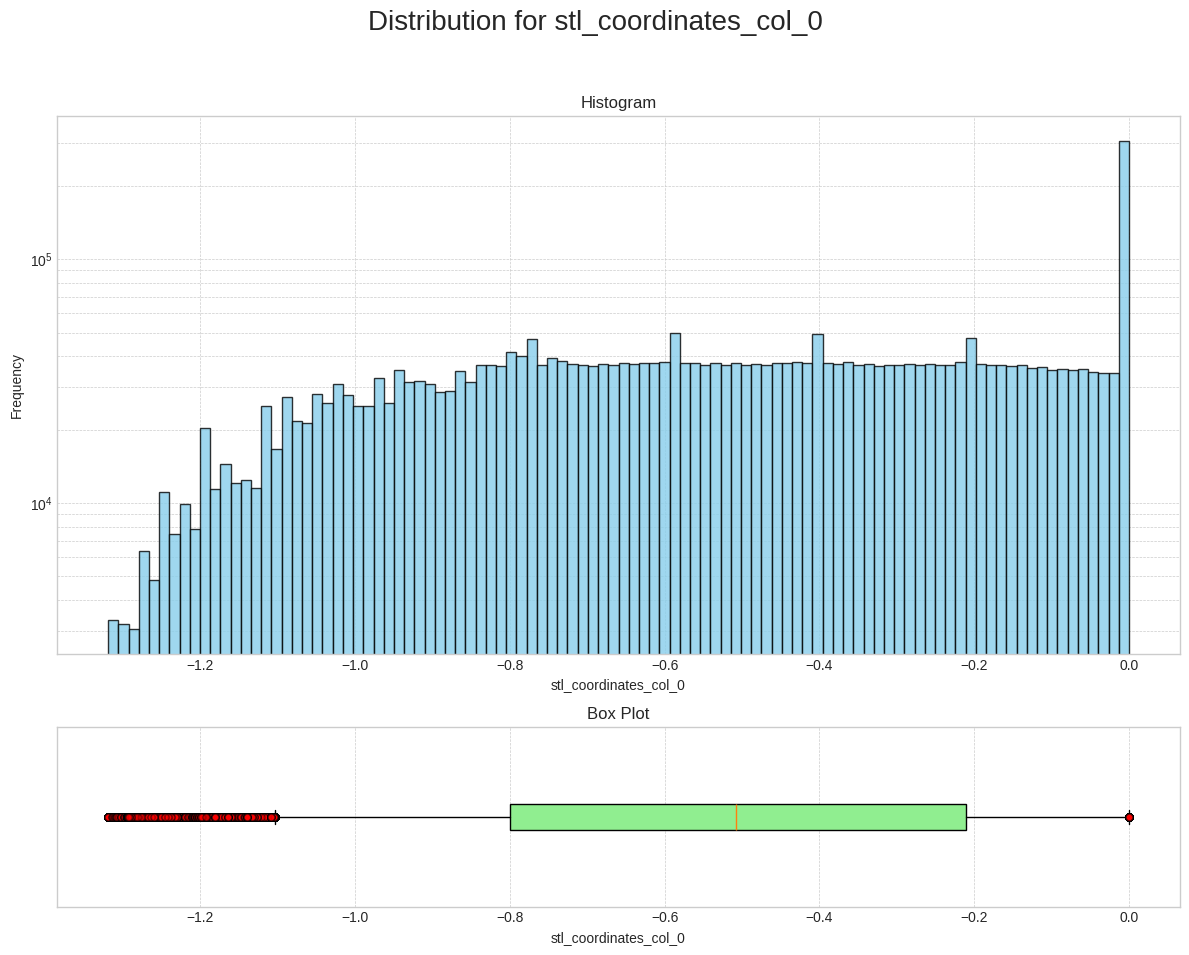


--------------- Analysis for: STL_COORDINATES_COL_1 ---------------
Shape of aggregated data: (3409996,)
Total values calculated: 3409996
Statistics:
  Min: 0.0000
  Max: 0.2545
  Mean: 0.1417
  Std Dev: 0.0736

--- Percentile Distribution ---
   1th percentile: 0.0029
   5th percentile: 0.0146
  25th percentile: 0.0791
  50th percentile: 0.1582
  75th percentile: 0.2022
  95th percentile: 0.2445
  99th percentile: 0.2545
***************************************



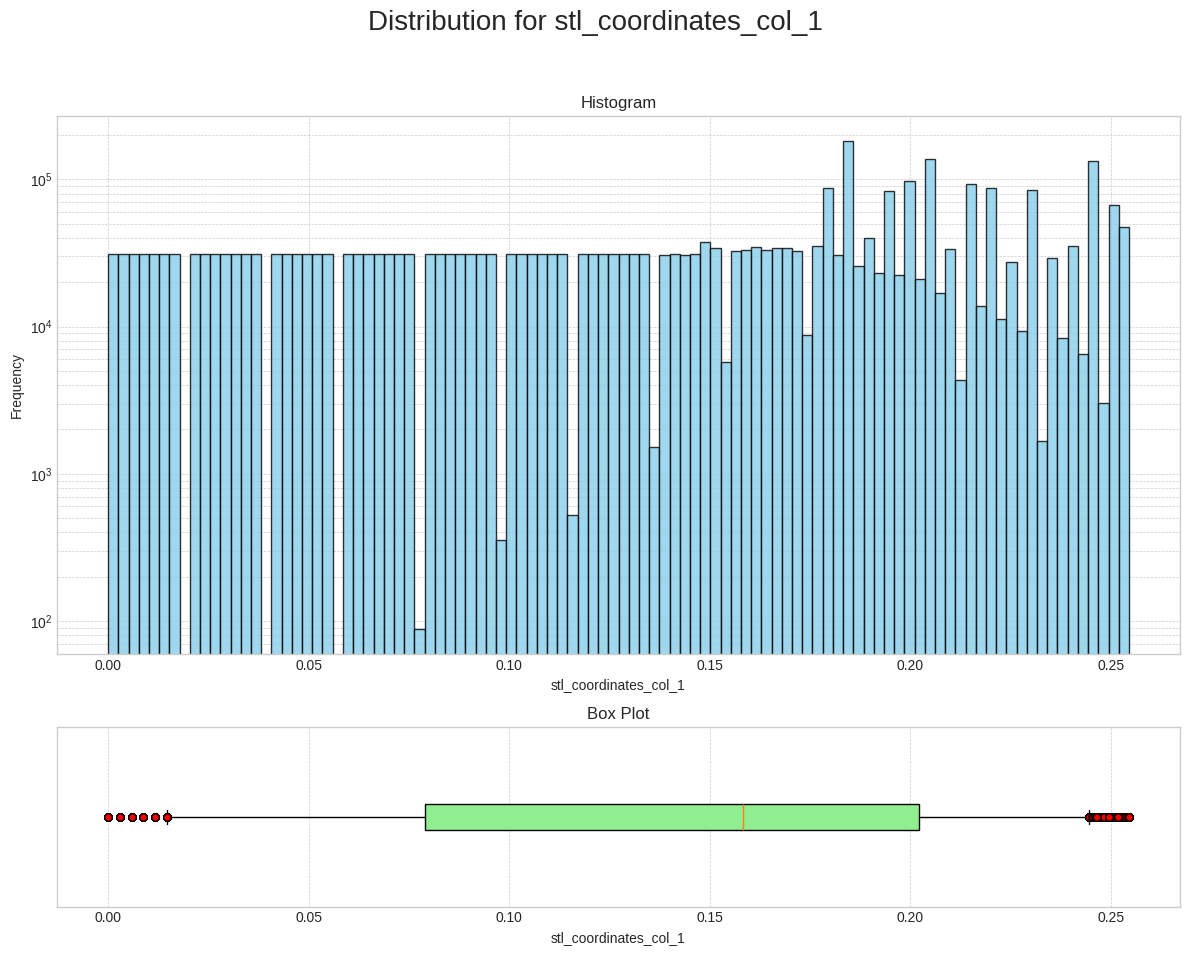


--------------- Analysis for: STL_COORDINATES_COL_2 ---------------
Shape of aggregated data: (3409996,)
Total values calculated: 3409996
Statistics:
  Min: 0.0000
  Max: 0.4105
  Mean: 0.1880
  Std Dev: 0.1178

--- Percentile Distribution ---
   1th percentile: 0.0300
   5th percentile: 0.0325
  25th percentile: 0.0700
  50th percentile: 0.1816
  75th percentile: 0.2988
  95th percentile: 0.3705
  99th percentile: 0.4055
***************************************



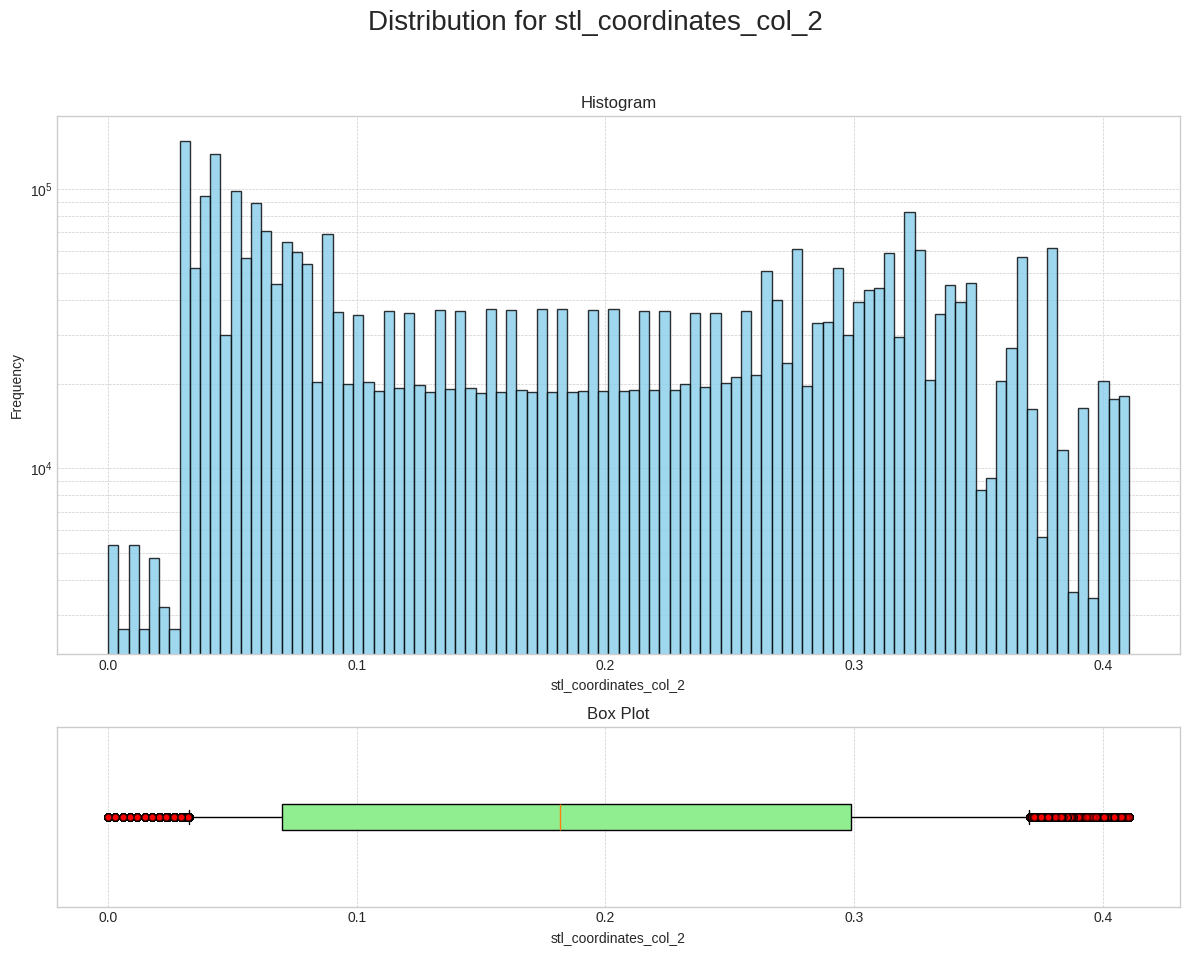


--------------- Analysis for: STL_CENTERS_COL_0 ---------------
Shape of aggregated data: (6786207,)
Total values calculated: 6786207
Statistics:
  Min: -1.3190
  Max: 0.0000
  Mean: -0.5191
  Std Dev: 0.3523

--- Percentile Distribution ---
   1th percentile: -1.2359
   5th percentile: -1.1024
  25th percentile: -0.7982
  50th percentile: -0.5089
  75th percentile: -0.2124
  95th percentile: -0.0000
  99th percentile: -0.0000
***************************************



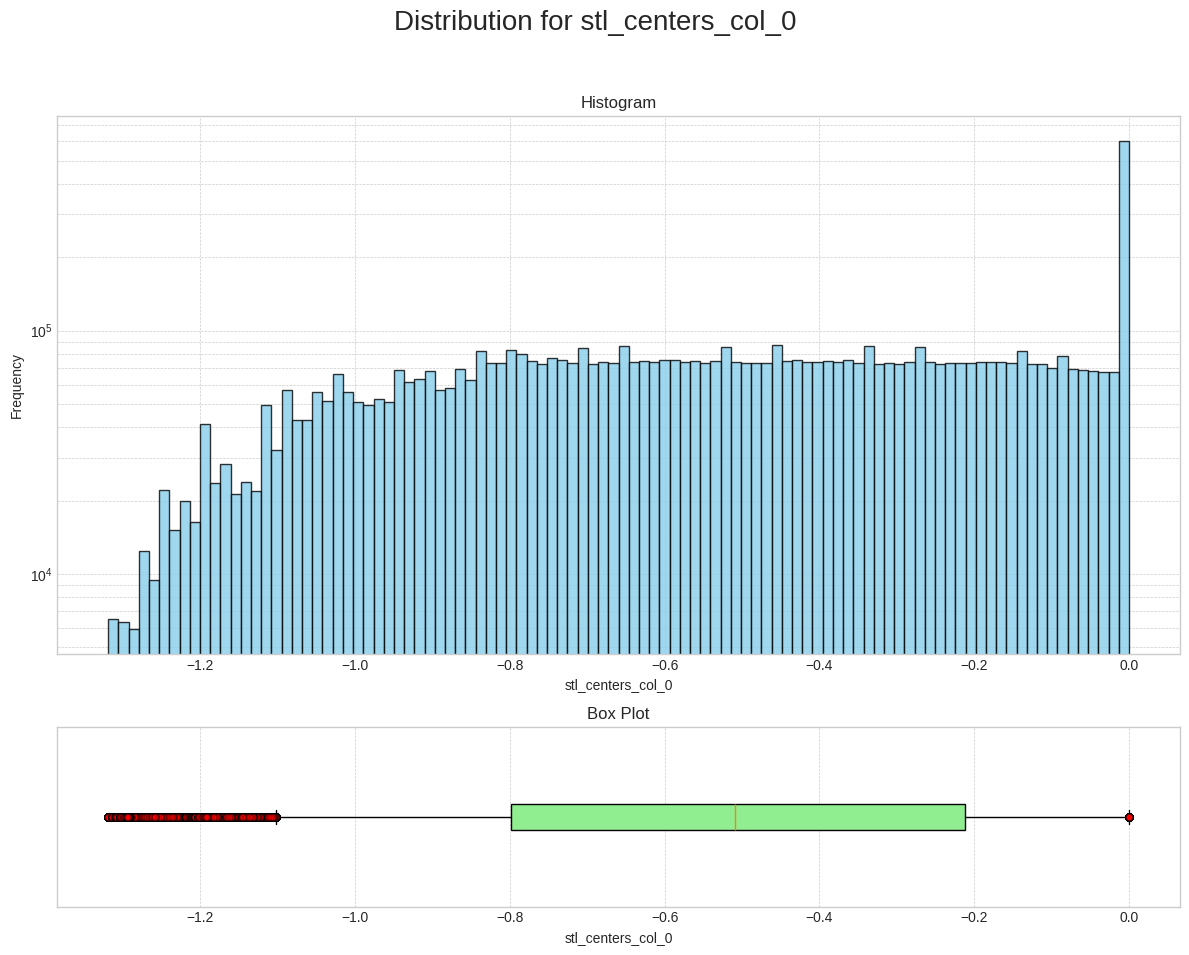


--------------- Analysis for: STL_CENTERS_COL_1 ---------------
Shape of aggregated data: (6786207,)
Total values calculated: 6786207
Statistics:
  Min: 0.0010
  Max: 0.2545
  Mean: 0.1424
  Std Dev: 0.0731

--- Percentile Distribution ---
   1th percentile: 0.0039
   5th percentile: 0.0156
  25th percentile: 0.0801
  50th percentile: 0.1572
  75th percentile: 0.2036
  95th percentile: 0.2445
  99th percentile: 0.2545
***************************************



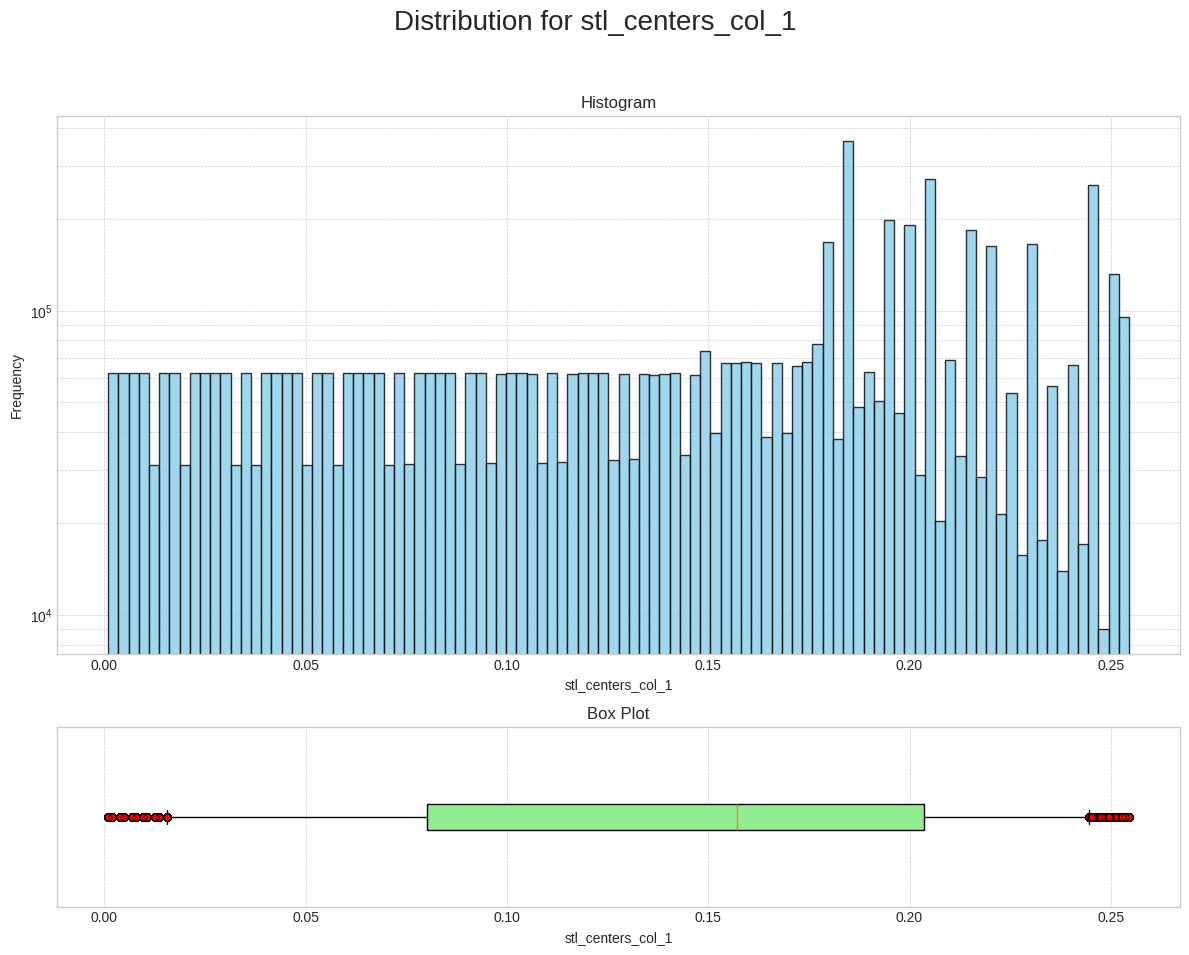


--------------- Analysis for: STL_CENTERS_COL_2 ---------------
Shape of aggregated data: (6786207,)
Total values calculated: 6786207
Statistics:
  Min: 0.0010
  Max: 0.4105
  Mean: 0.1881
  Std Dev: 0.1177

--- Percentile Distribution ---
   1th percentile: 0.0300
   5th percentile: 0.0325
  25th percentile: 0.0700
  50th percentile: 0.1826
  75th percentile: 0.2980
  95th percentile: 0.3705
  99th percentile: 0.4055
***************************************



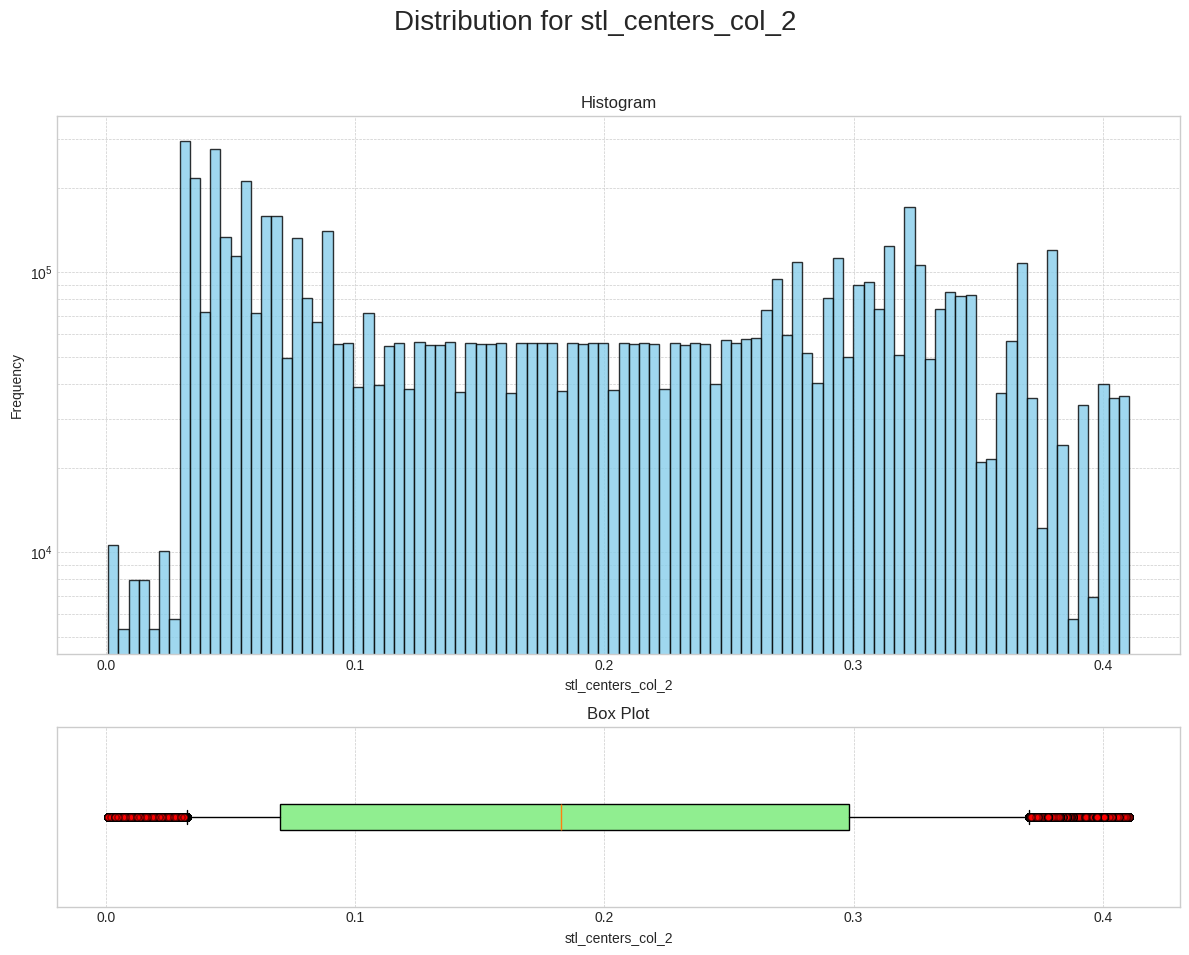


--------------- Analysis for: STL_FACES ---------------
Shape of aggregated data: (20358621,)
Total values calculated: 20358621
Statistics:
  Min: 0.0000
  Max: 94265.0000
  Mean: 35054.5273
  Std Dev: 21316.7383

--- Percentile Distribution ---
   1th percentile: 678.0000
   5th percentile: 3404.0000
  25th percentile: 17053.0000
  50th percentile: 34104.0000
  75th percentile: 51281.0000
  95th percentile: 71216.0000
  99th percentile: 83128.0000
***************************************



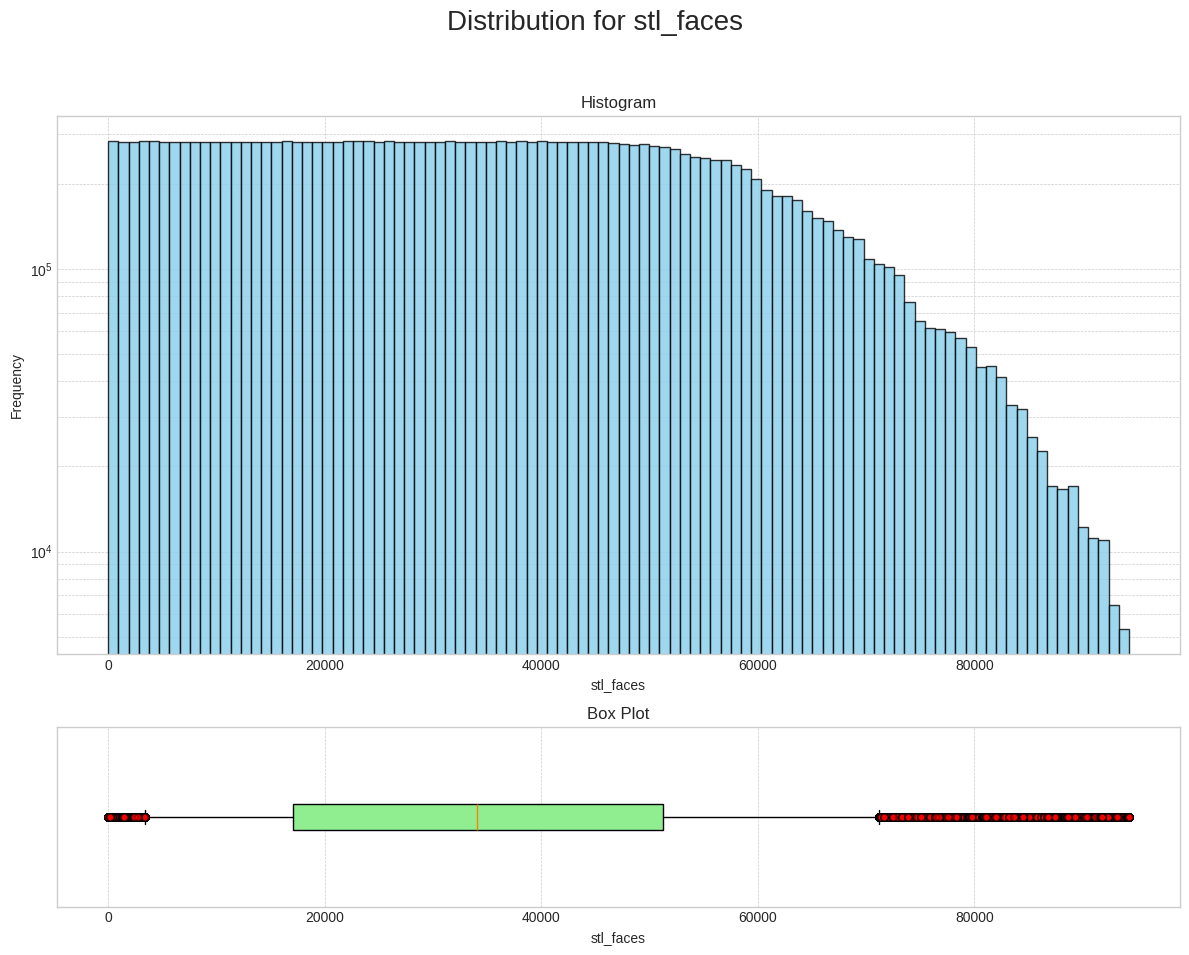


--------------- Analysis for: STL_AREAS ---------------
Shape of aggregated data: (6786207,)
Total values calculated: 6786207
Statistics:
  Min: 0.0000
  Max: 0.0000
  Mean: 0.0000
  Std Dev: 0.0000

--- Percentile Distribution ---
   1th percentile: 0.0000
   5th percentile: 0.0000
  25th percentile: 0.0000
  50th percentile: 0.0000
  75th percentile: 0.0000
  95th percentile: 0.0000
  99th percentile: 0.0000
***************************************



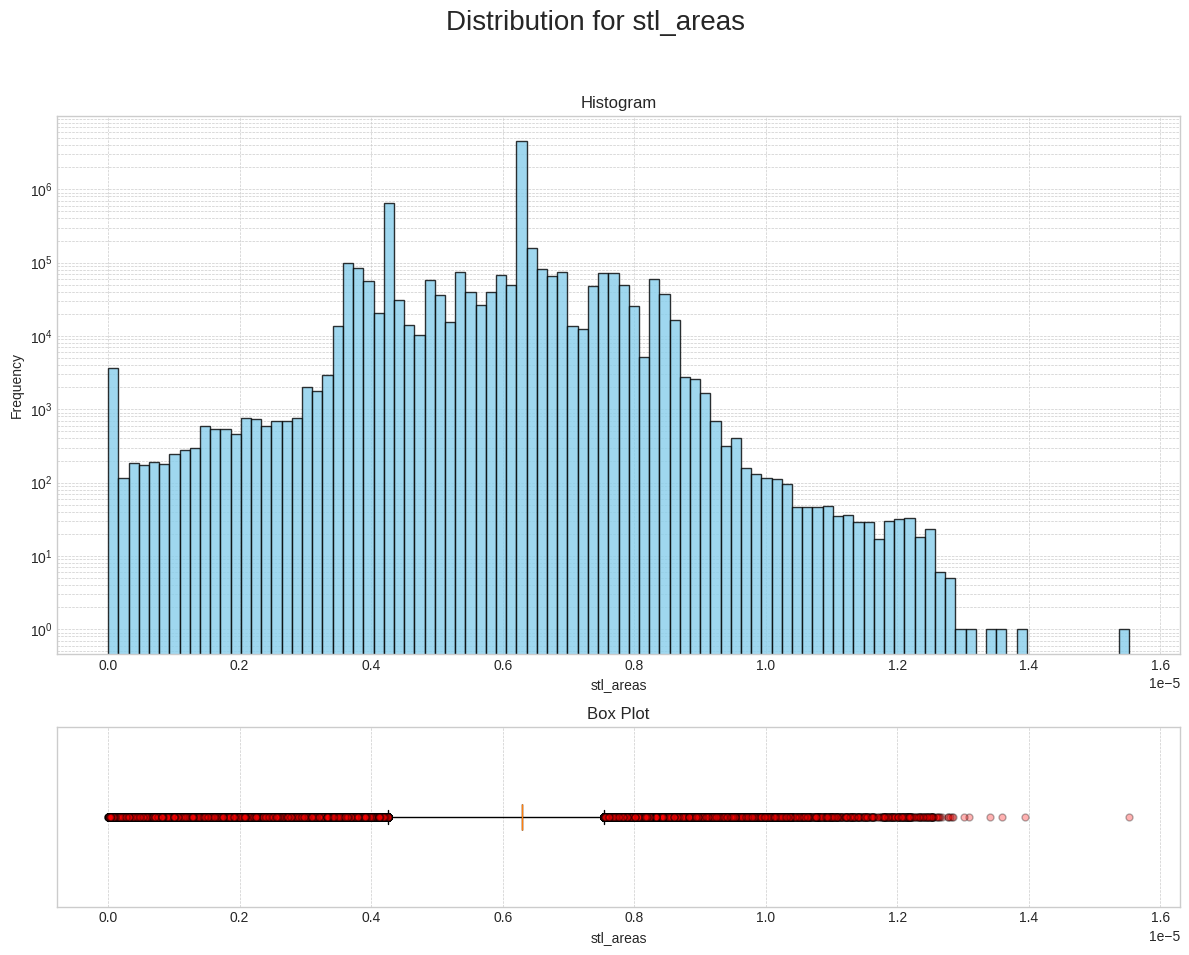


--------------- Analysis for: SURFACE_MESH_CENTERS_COL_0 ---------------
Shape of aggregated data: (3390457,)
Total values calculated: 3390457
Statistics:
  Min: -1.3190
  Max: 0.0000
  Mean: -0.5190
  Std Dev: 0.3522

--- Percentile Distribution ---
   1th percentile: -1.2354
   5th percentile: -1.1025
  25th percentile: -0.7975
  50th percentile: -0.5096
  75th percentile: -0.2131
  95th percentile: -0.0000
  99th percentile: -0.0000
***************************************



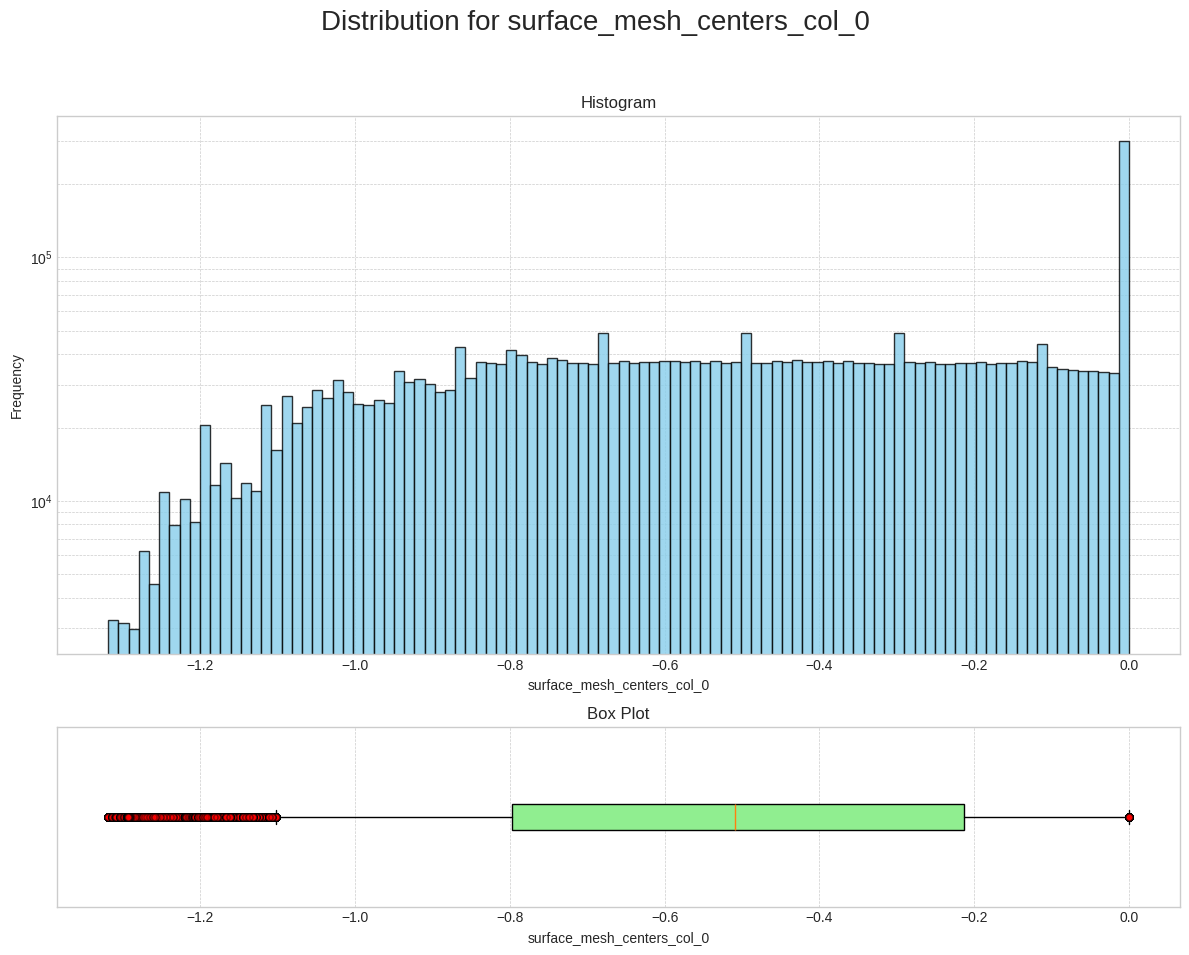


--------------- Analysis for: SURFACE_MESH_CENTERS_COL_1 ---------------
Shape of aggregated data: (3390457,)
Total values calculated: 3390457
Statistics:
  Min: 0.0015
  Max: 0.2545
  Mean: 0.1424
  Std Dev: 0.0731

--- Percentile Distribution ---
   1th percentile: 0.0044
   5th percentile: 0.0161
  25th percentile: 0.0806
  50th percentile: 0.1567
  75th percentile: 0.2036
  95th percentile: 0.2445
  99th percentile: 0.2545
***************************************



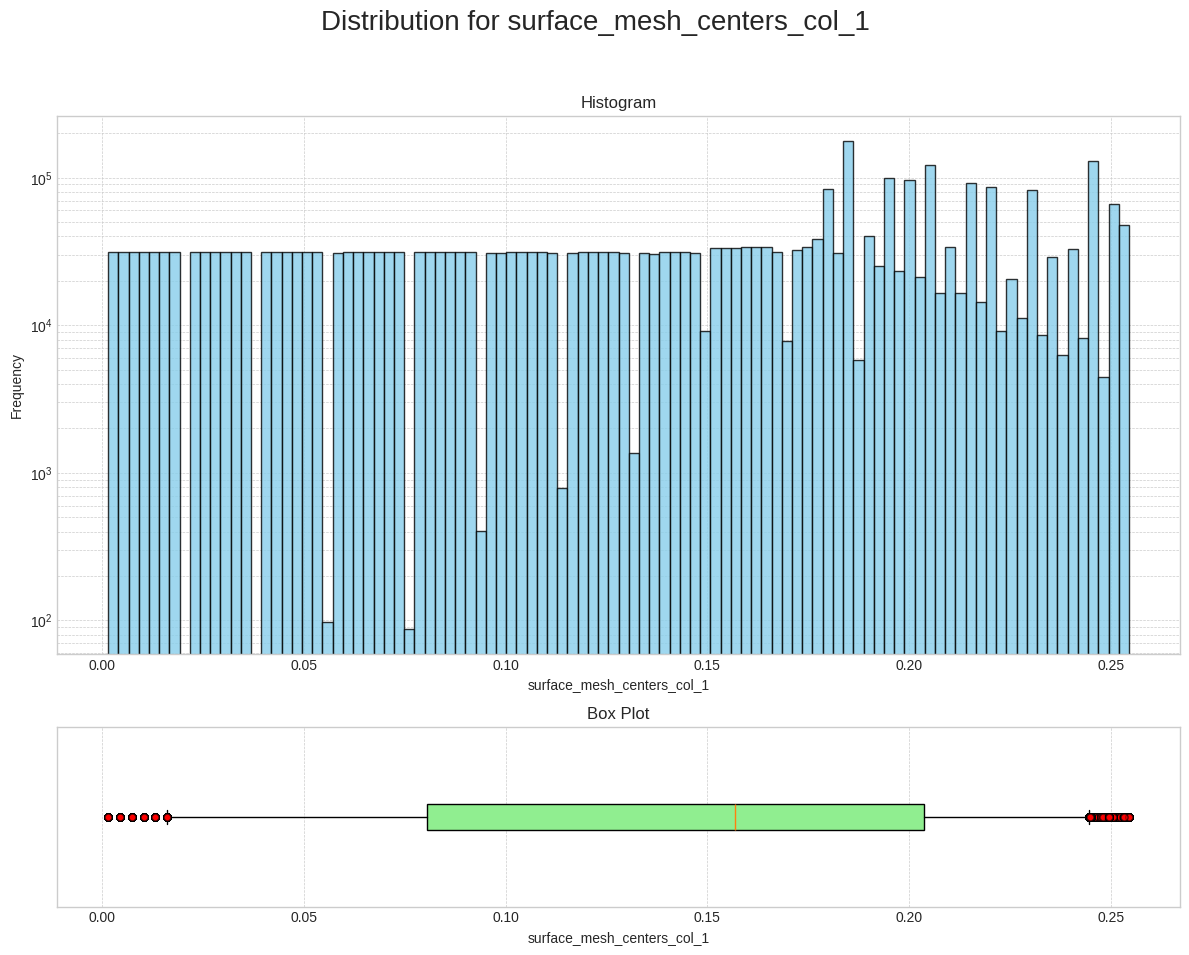


--------------- Analysis for: SURFACE_MESH_CENTERS_COL_2 ---------------
Shape of aggregated data: (3390457,)
Total values calculated: 3390457
Statistics:
  Min: 0.0015
  Max: 0.4105
  Mean: 0.1881
  Std Dev: 0.1177

--- Percentile Distribution ---
   1th percentile: 0.0300
   5th percentile: 0.0325
  25th percentile: 0.0700
  50th percentile: 0.1831
  75th percentile: 0.2980
  95th percentile: 0.3705
  99th percentile: 0.4055
***************************************



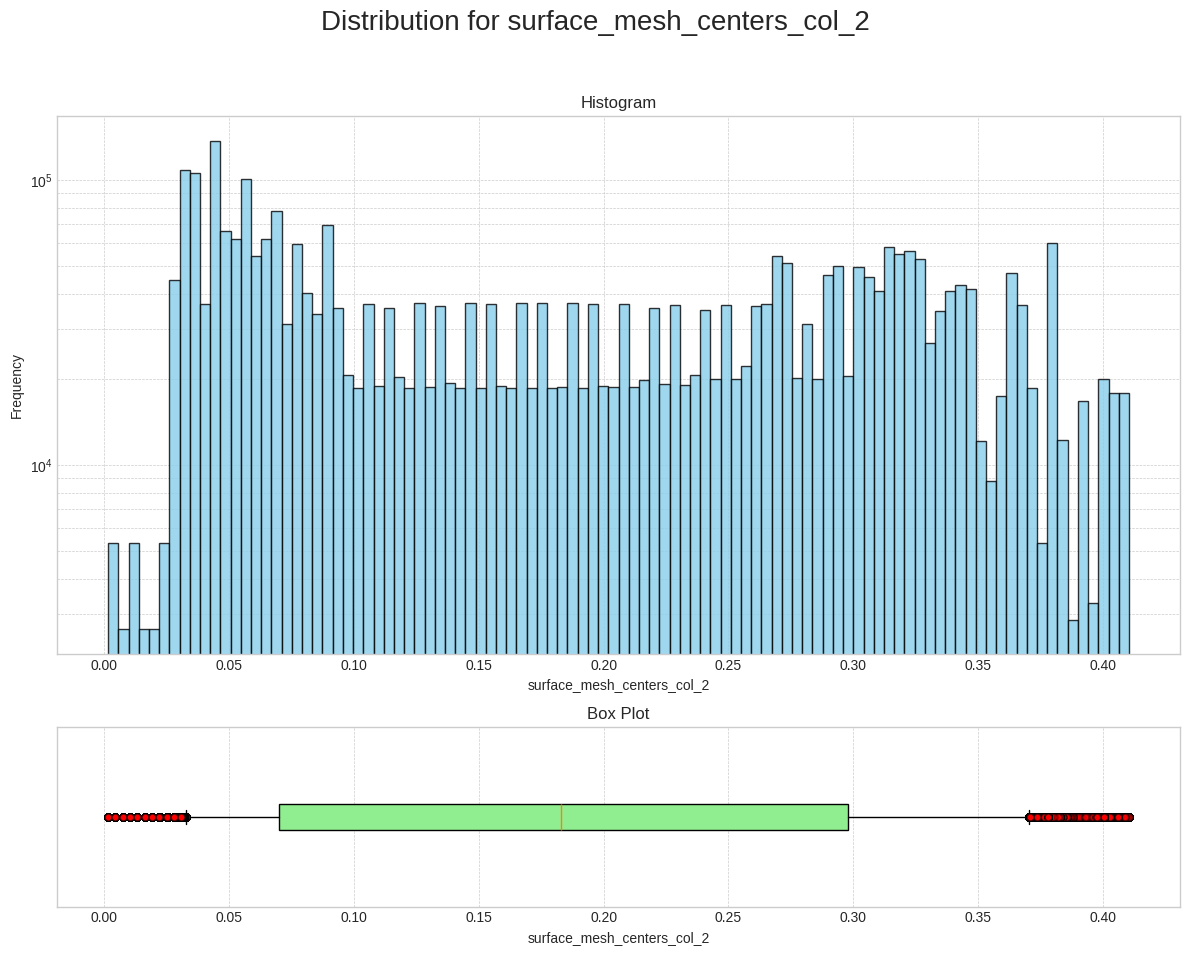


--------------- Analysis for: SURFACE_NORMALS_COL_0 ---------------
Shape of aggregated data: (3390457,)
Total values calculated: 3390457
Statistics:
  Min: -1.0000
  Max: 1.0000
  Mean: -0.0072
  Std Dev: 0.4062

--- Percentile Distribution ---
   1th percentile: -1.0000
   5th percentile: -1.0000
  25th percentile: 0.0000
  50th percentile: 0.0000
  75th percentile: 0.0000
  95th percentile: 0.8932
  99th percentile: 1.0000
***************************************



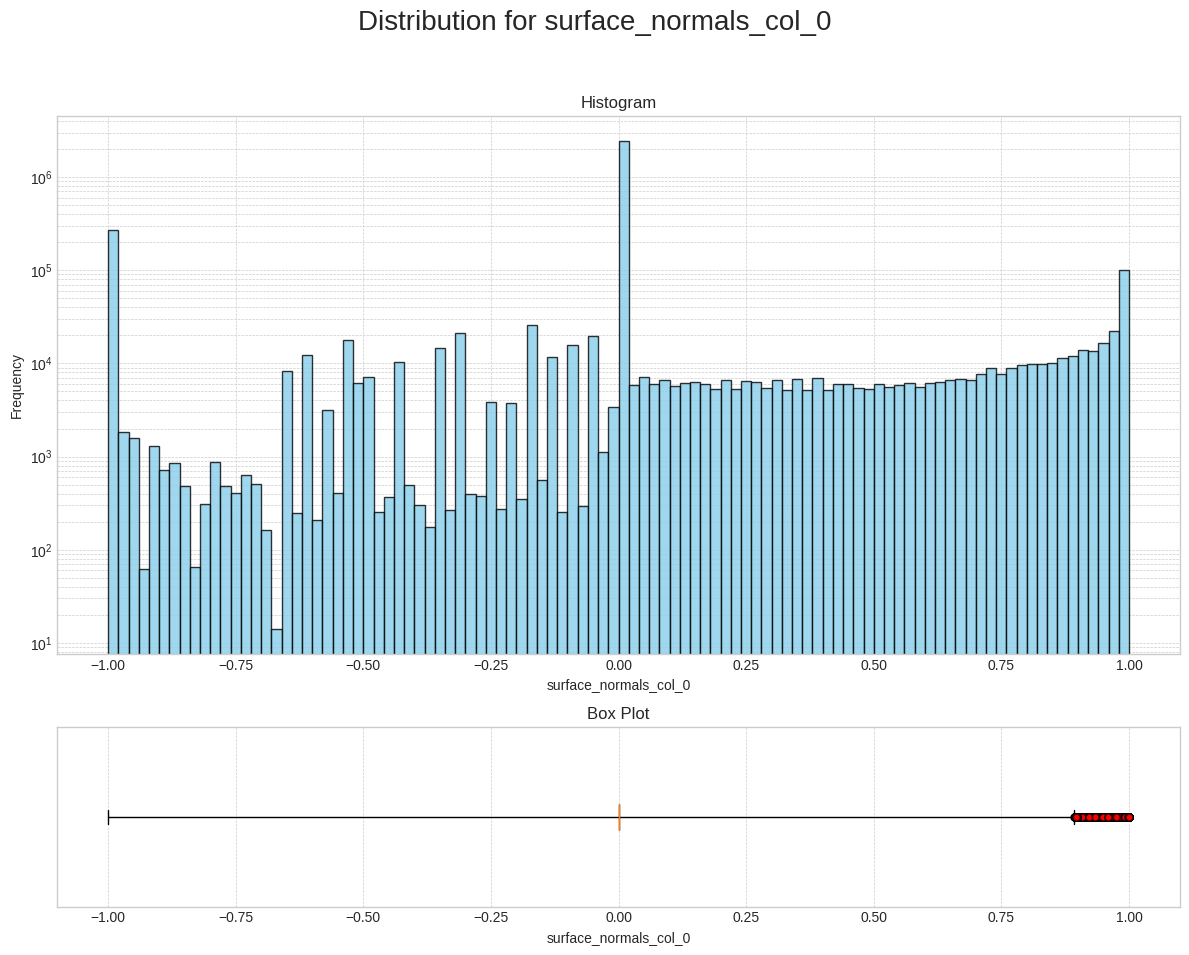


--------------- Analysis for: SURFACE_NORMALS_COL_1 ---------------
Shape of aggregated data: (3390457,)
Total values calculated: 3390457
Statistics:
  Min: -1.0000
  Max: 1.0000
  Mean: -0.3346
  Std Dev: 0.4722

--- Percentile Distribution ---
   1th percentile: -1.0000
   5th percentile: -1.0000
  25th percentile: -1.0000
  50th percentile: 0.0000
  75th percentile: 0.0000
  95th percentile: 0.0000
  99th percentile: 0.0000
***************************************



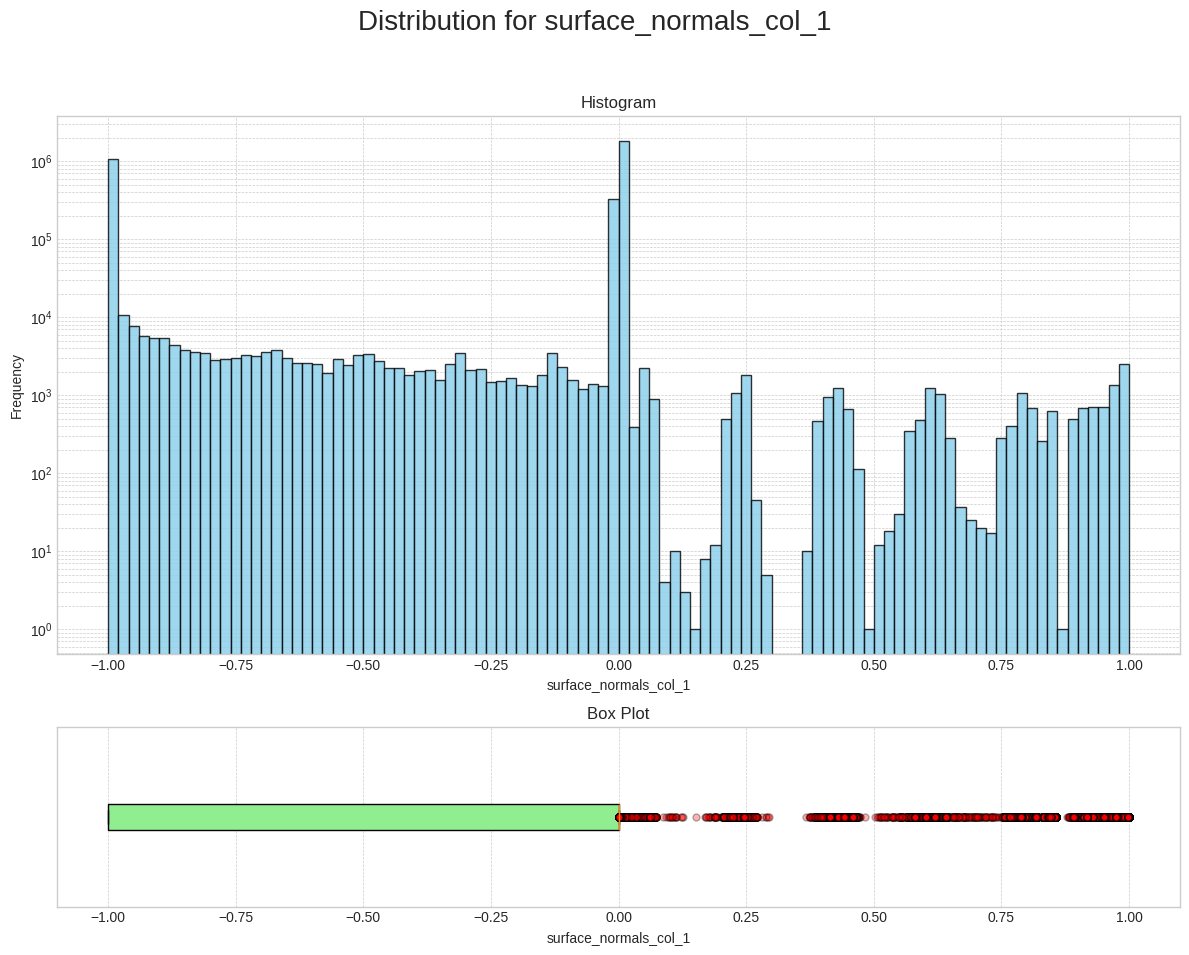


--------------- Analysis for: SURFACE_NORMALS_COL_2 ---------------
Shape of aggregated data: (3390457,)
Total values calculated: 3390457
Statistics:
  Min: -1.0000
  Max: 1.0000
  Mean: 0.0009
  Std Dev: 0.7071

--- Percentile Distribution ---
   1th percentile: -1.0000
   5th percentile: -1.0000
  25th percentile: -0.7730
  50th percentile: 0.0000
  75th percentile: 0.7563
  95th percentile: 1.0000
  99th percentile: 1.0000
***************************************



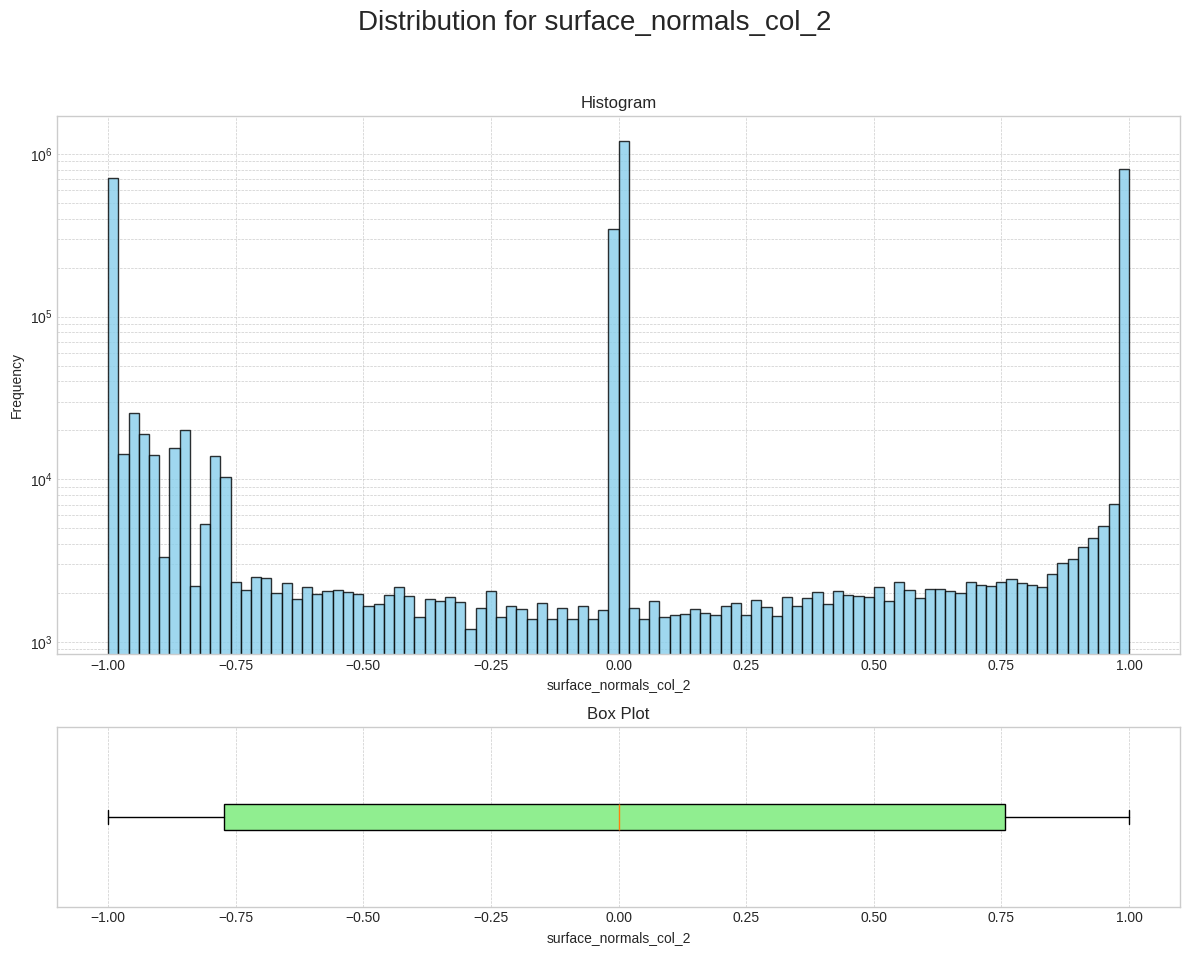


--------------- Analysis for: SURFACE_AREAS ---------------
Shape of aggregated data: (3390457,)
Total values calculated: 3390457
Statistics:
  Min: 0.0000
  Max: 0.0000
  Mean: 0.0000
  Std Dev: 0.0000

--- Percentile Distribution ---
   1th percentile: 0.0000
   5th percentile: 0.0000
  25th percentile: 0.0000
  50th percentile: 0.0000
  75th percentile: 0.0000
  95th percentile: 0.0000
  99th percentile: 0.0000
***************************************



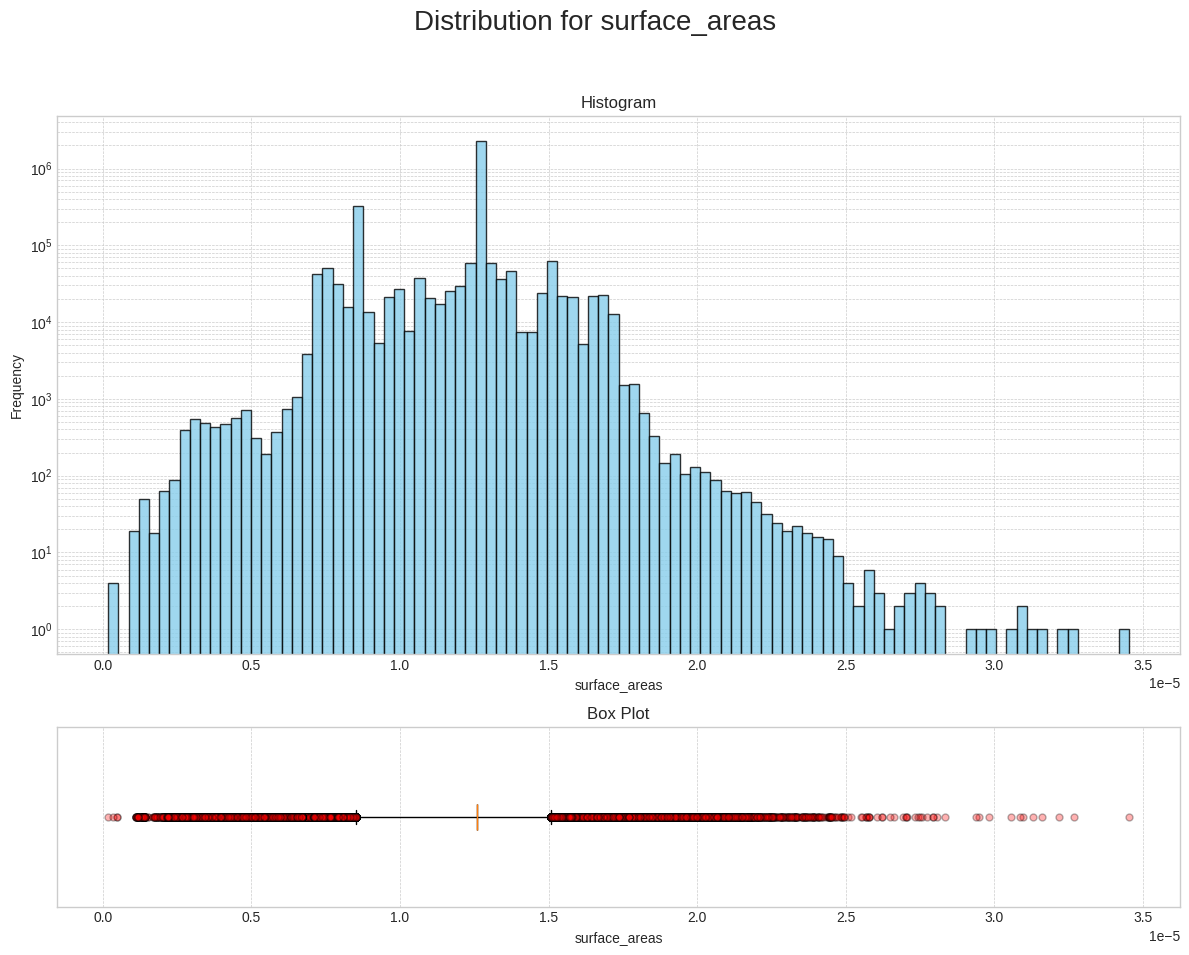


--------------- Analysis for: SURFACE_FIELDS_COL_0 ---------------
Shape of aggregated data: (3390457,)
Total values calculated: 3390457
Statistics:
  Min: -1.3584
  Max: 0.4090
  Mean: -0.0856
  Std Dev: 0.1431

--- Percentile Distribution ---
   1th percentile: -0.5644
   5th percentile: -0.3644
  25th percentile: -0.1027
  50th percentile: -0.0613
  75th percentile: -0.0437
  95th percentile: 0.1185
  99th percentile: 0.3820
***************************************



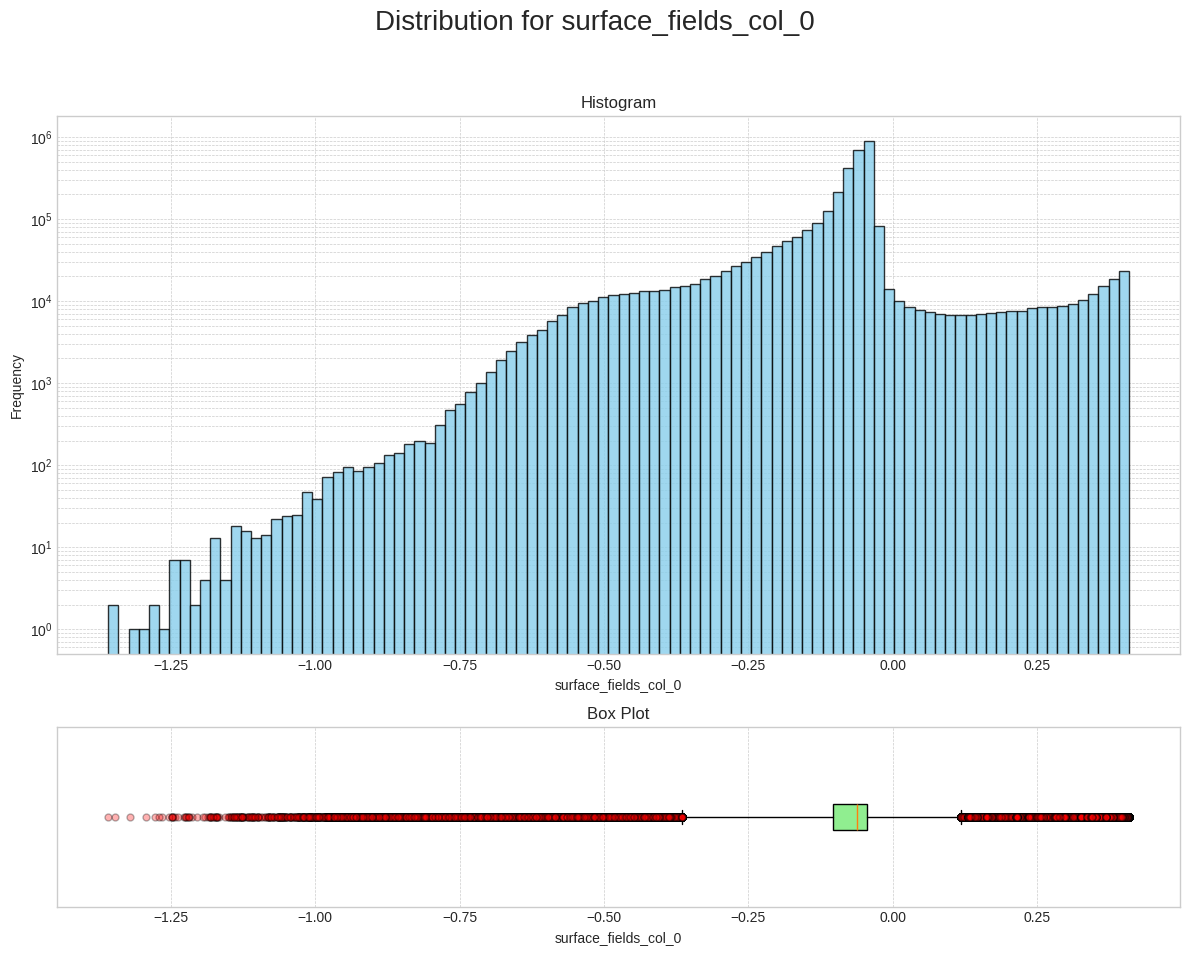


--------------- Analysis for: GLOBAL_PARAMS_VALUES ---------------
Shape of aggregated data: (100,)
Total values calculated: 100
Statistics:
  Min: 1.2260
  Max: 60.0000
  Mean: 20.7380
  Std Dev: 21.1394

--- Percentile Distribution ---
   1th percentile: 1.2260
   5th percentile: 1.2260
  25th percentile: 1.2260
  50th percentile: 10.6130
  75th percentile: 40.0000
  95th percentile: 55.0000
  99th percentile: 60.0000
***************************************



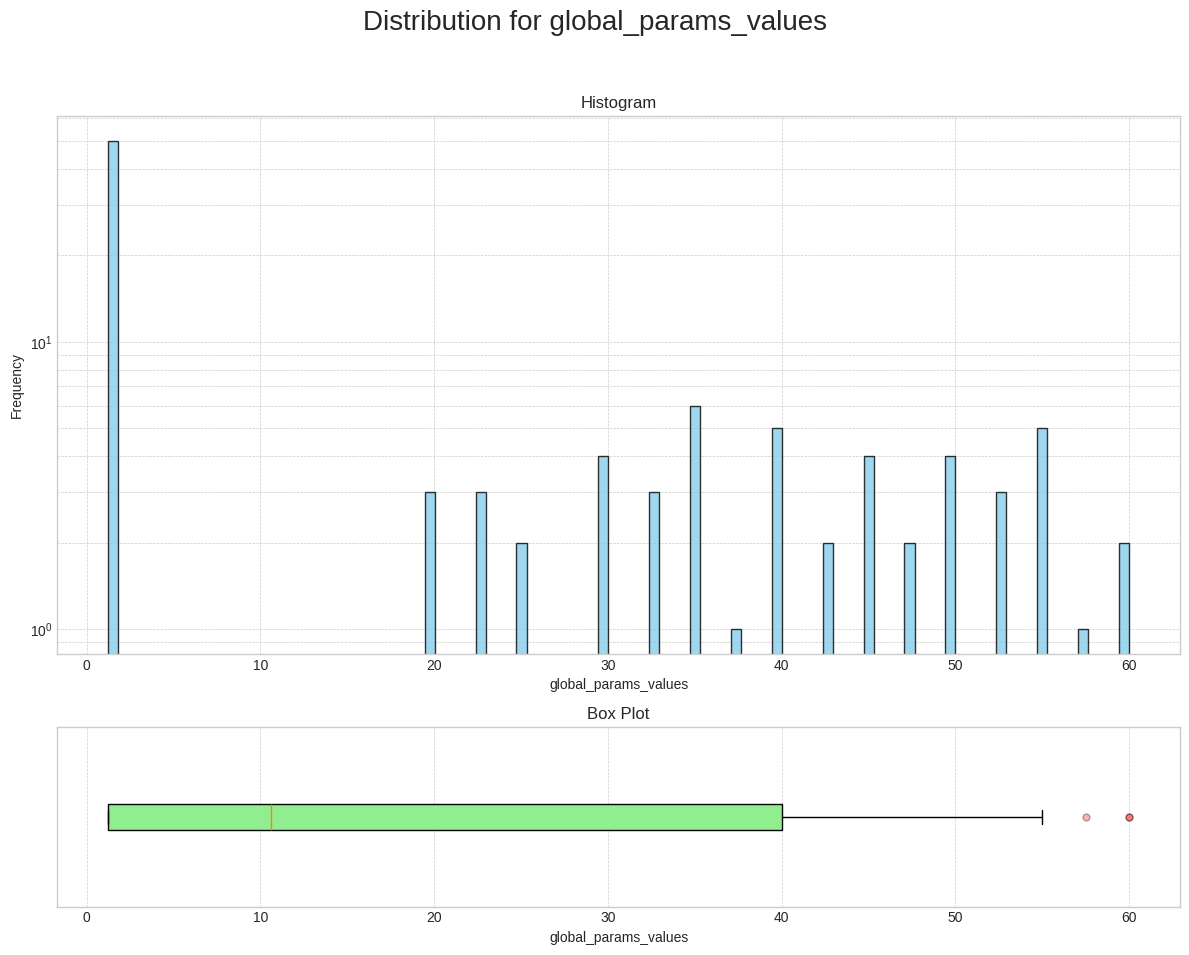


--------------- Analysis for: GLOBAL_PARAMS_REFERENCE ---------------
Shape of aggregated data: (100,)
Total values calculated: 100
Statistics:
  Min: 1.2260
  Max: 50.0000
  Mean: 25.6130
  Std Dev: 24.3870

--- Percentile Distribution ---
   1th percentile: 1.2260
   5th percentile: 1.2260
  25th percentile: 1.2260
  50th percentile: 25.6130
  75th percentile: 50.0000
  95th percentile: 50.0000
  99th percentile: 50.0000
***************************************



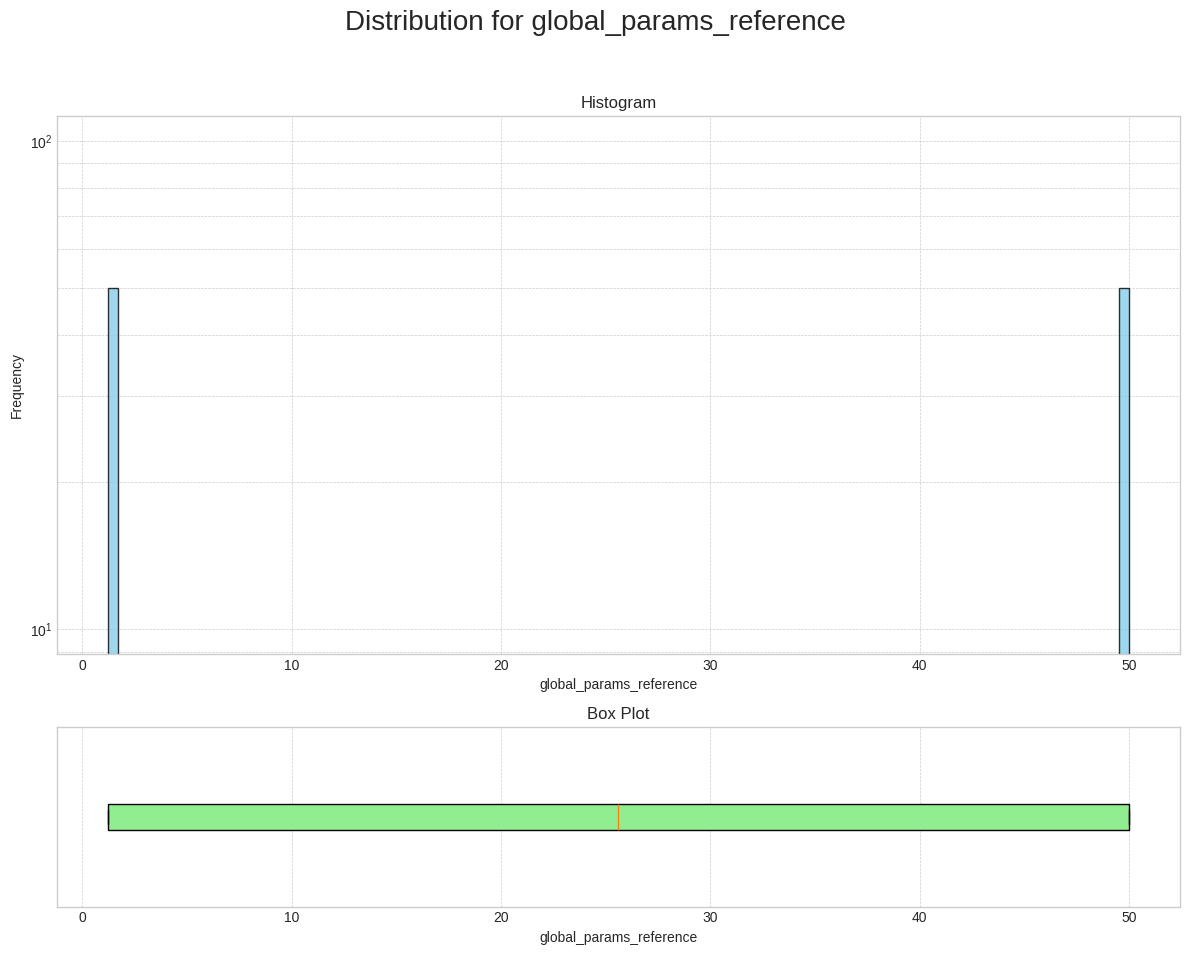

In [1]:
from utils import process_and_plot_directory, analyze_and_plot_distribution

# Define the directory where your .npy files are located
# Please change this path to your actual data directory
NPY_DIRECTORY = "/workspace/physicsnemo_ahmed_body_dataset_vv1/dataset/validation_prepared_surface_data"
# Analyze all data in the specified directory
process_and_plot_directory(NPY_DIRECTORY)

<hr><br>

## Ready for Neural Operator Training

With our data properly prepared, we're now ready to dive into training DoMINO, the neural operator that will learn to predict aerodynamic fields directly from geometry. In the next notebook, we'll explore the DoMINO architecture and see how this preprocessed data enables rapid aerodynamic predictions that traditionally require expensive CFD simulations.

<img src="images/nvidia_header.png" style="margin-left: -30px; width: 300px; float: left;">